### Road Sign Classification Using  Pytorch Resnet18

#### Train a convolutional neural network for image classification using Transfer Learning

#### 1. Finetuning the convnet: Instead of random initialization , we initialize the network with a pretrained network, like the onw that is trained on imagenet 1000 dataset. 
#### 2. ConvNet as fixed feature extractor: Here we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new ine with random weights and only this layer is trained.

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

### Load Data

We will use torchvision and torch.utils.data packages for loading the data

The problem we are going to solve today is to train a model to classify road signs . We are using GTSRB data set. It is  Single-image, multi-class classification problem with more than 40 classes and 50,000 images in total.

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = data_dir = r"C:\Users\Rekha\Documents\pytorch_image_classification"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
    

In [3]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

### Visualize a few images


Let's visualize a few training images so as to understand the data augmentations.

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20, 20))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20, 20))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

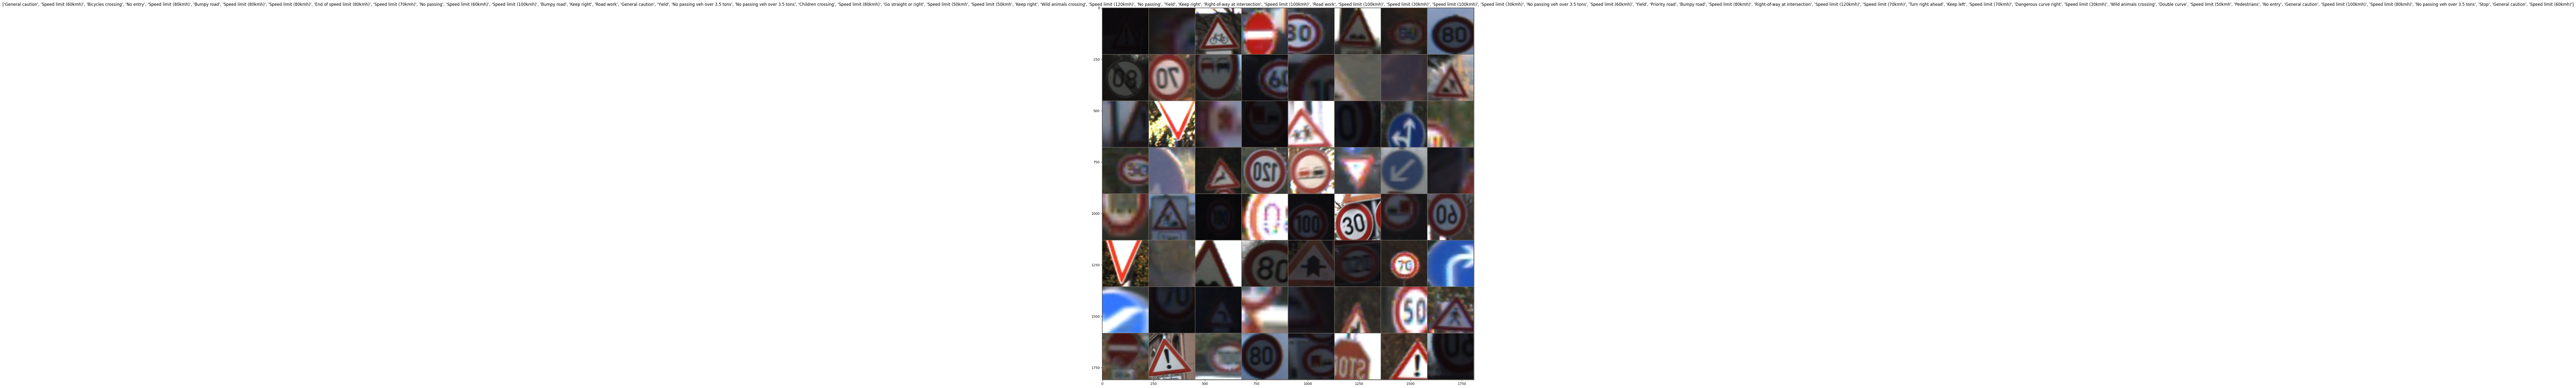

In [8]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

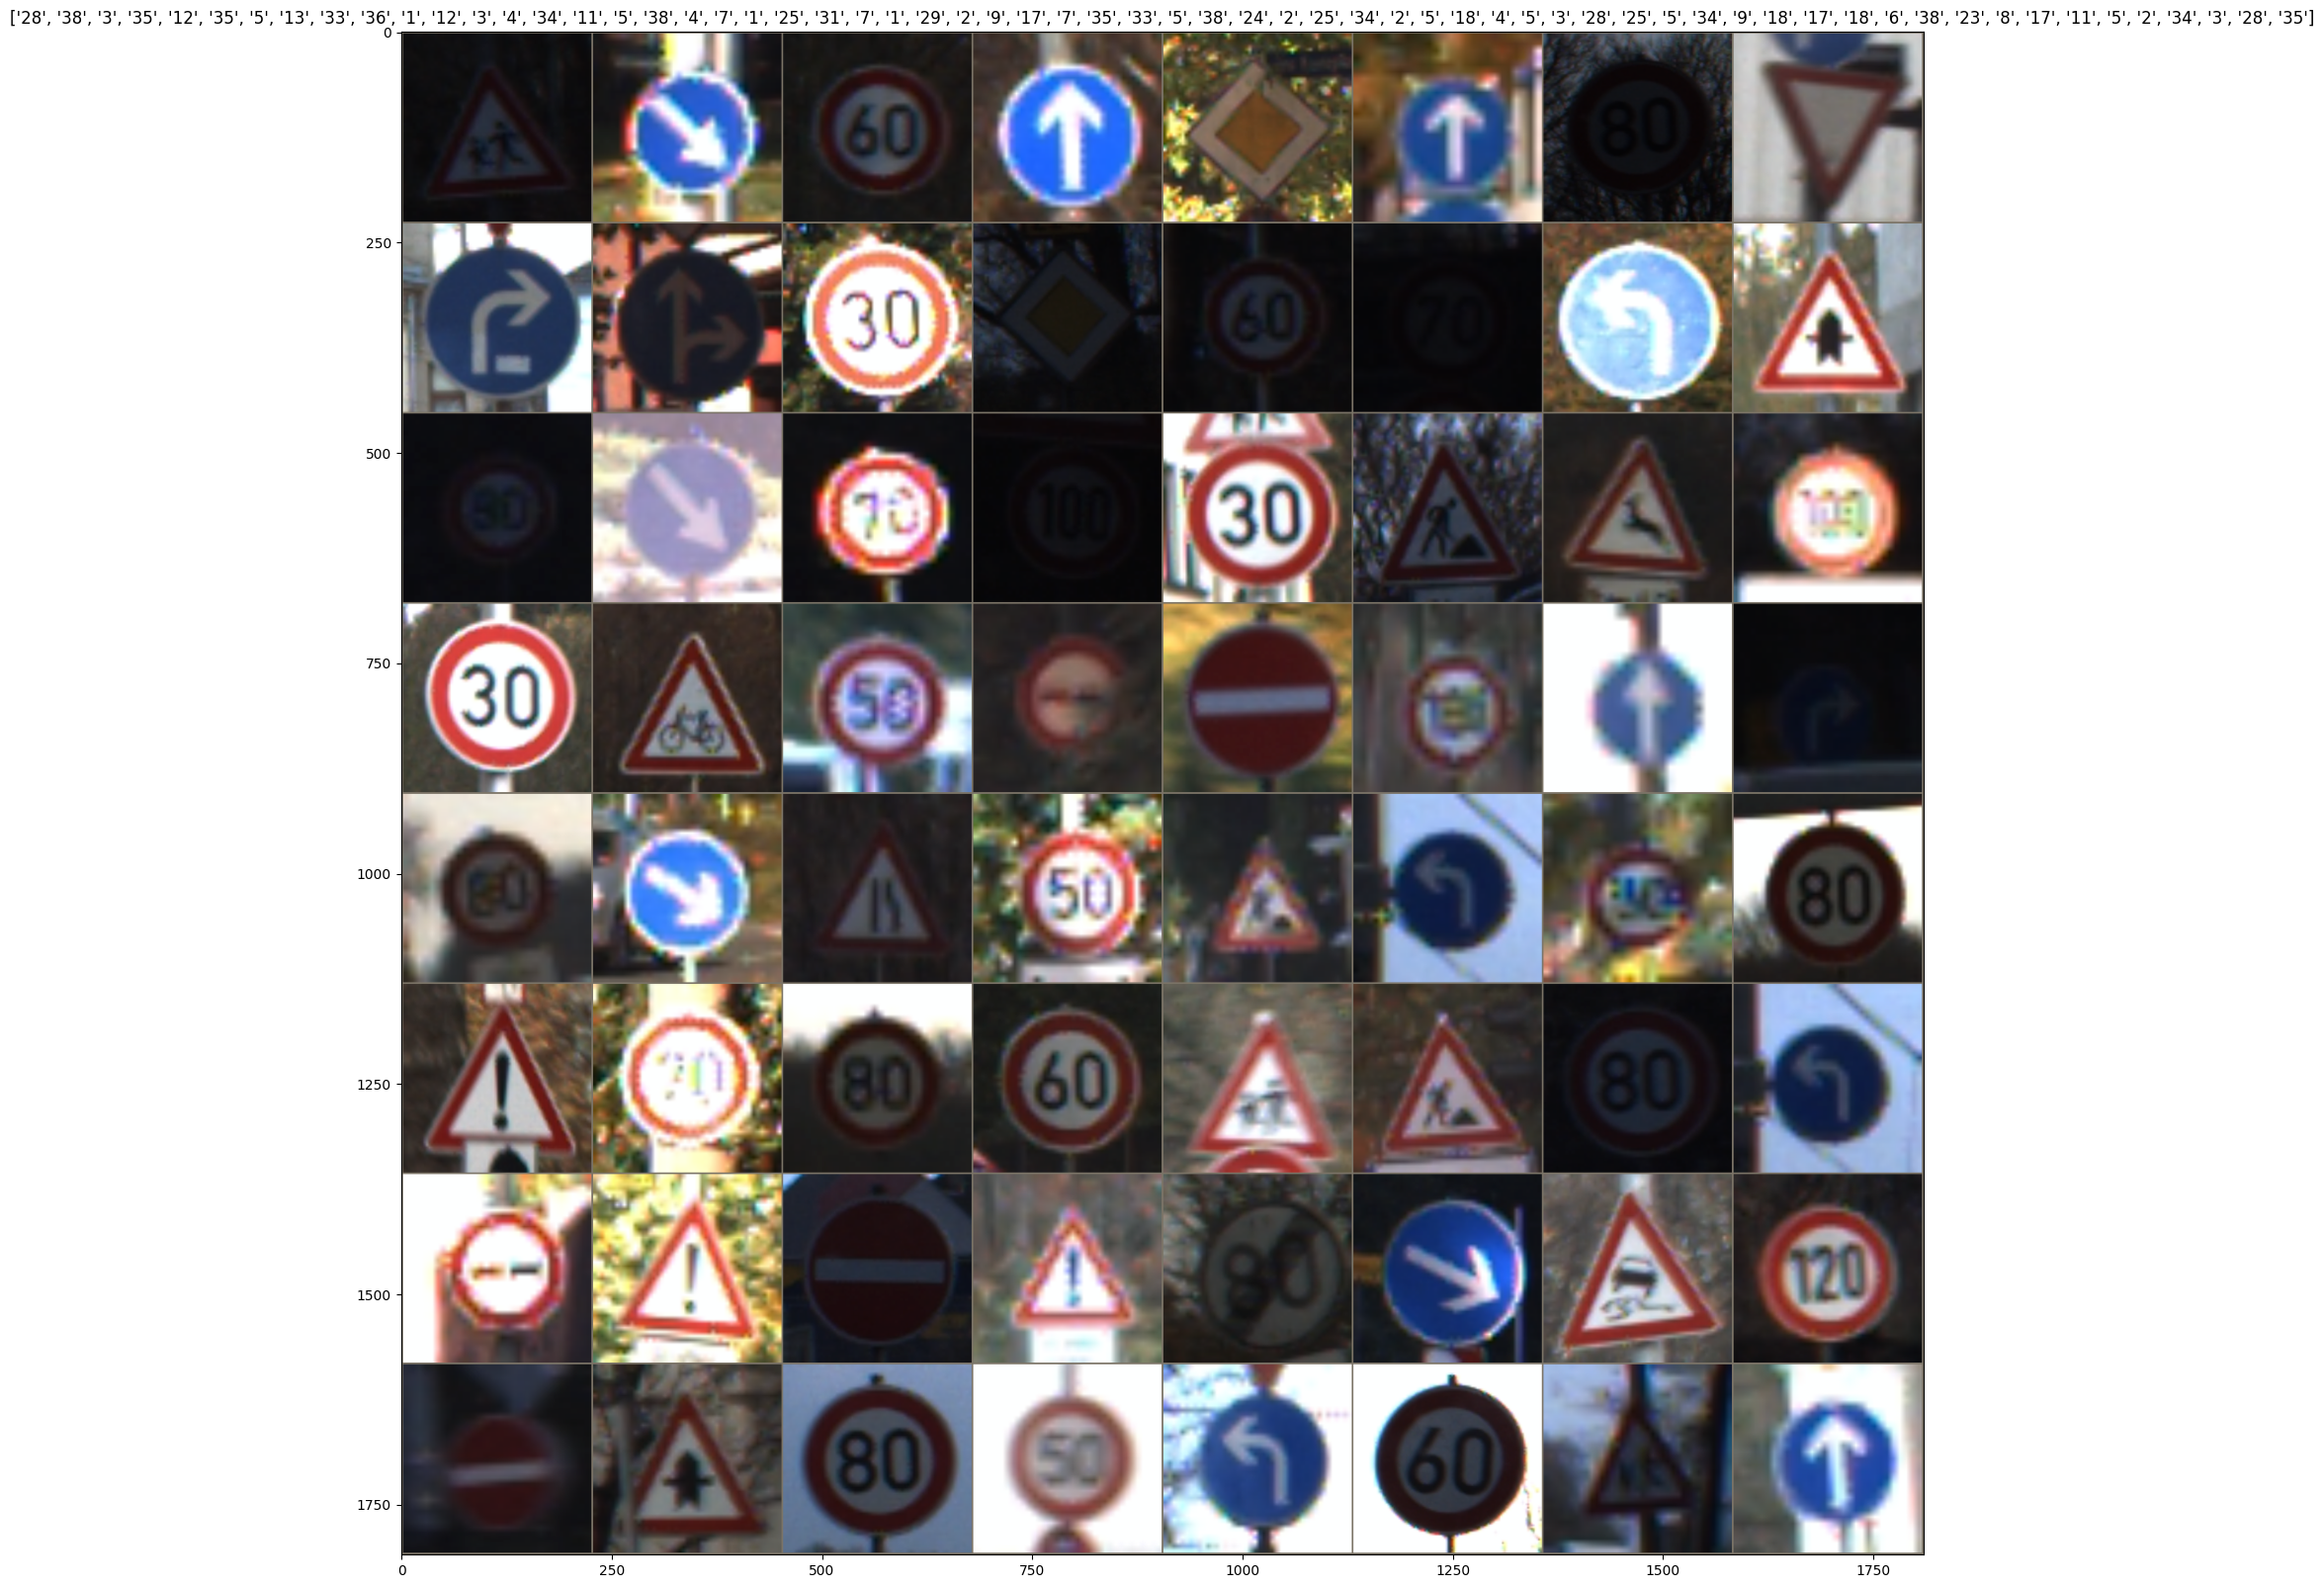

In [30]:
inputs, classes = next(iter(dataloaders))

# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training the model 

General function to train a model also to illustrate :

. Scheduling the leaning rate

. Saving the best model

In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.


In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### visualizing the model predictions

Generic function to display predictions for a few images

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Finetuning the convet

Load a pretrained model and reset final fully connected layer.

In [11]:
model_ft = models.resnet18(pretrained =True)
num_ftrs= model_ft.fc.in_features
number_of_classes =43
model_ft.fc=nn.Linear(num_ftrs,number_of_classes)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


### Train and evaluate

This is expected as gradients don't need to be computed for most of the network. However, forward does need to be computed.


In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4501 Acc: 0.6202
test Loss: 0.2847 Acc: 0.9320

Epoch 1/24
----------
train Loss: 0.4899 Acc: 0.8635
test Loss: 0.1241 Acc: 0.9577

Epoch 2/24
----------
train Loss: 0.3572 Acc: 0.8957
test Loss: 0.0808 Acc: 0.9757

Epoch 3/24
----------
train Loss: 0.2951 Acc: 0.9108
test Loss: 0.0607 Acc: 0.9825

Epoch 4/24
----------
train Loss: 0.2681 Acc: 0.9181
test Loss: 0.0414 Acc: 0.9898

Epoch 5/24
----------
train Loss: 0.2419 Acc: 0.9269
test Loss: 0.0302 Acc: 0.9941

Epoch 6/24
----------
train Loss: 0.2223 Acc: 0.9325
test Loss: 0.0287 Acc: 0.9920

Epoch 7/24
----------
train Loss: 0.2035 Acc: 0.9373
test Loss: 0.0230 Acc: 0.9948

Epoch 8/24
----------
train Loss: 0.2027 Acc: 0.9375
test Loss: 0.0231 Acc: 0.9948

Epoch 9/24
----------
train Loss: 0.1966 Acc: 0.9393
test Loss: 0.0220 Acc: 0.9954

Epoch 10/24
----------
train Loss: 0.1927 Acc: 0.9412
test Loss: 0.0205 Acc: 0.9959

Epoch 11/24
----------
train Loss: 0.1908 Acc: 0.9412
test Loss: 0.0211 Acc

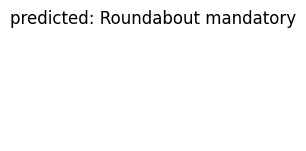

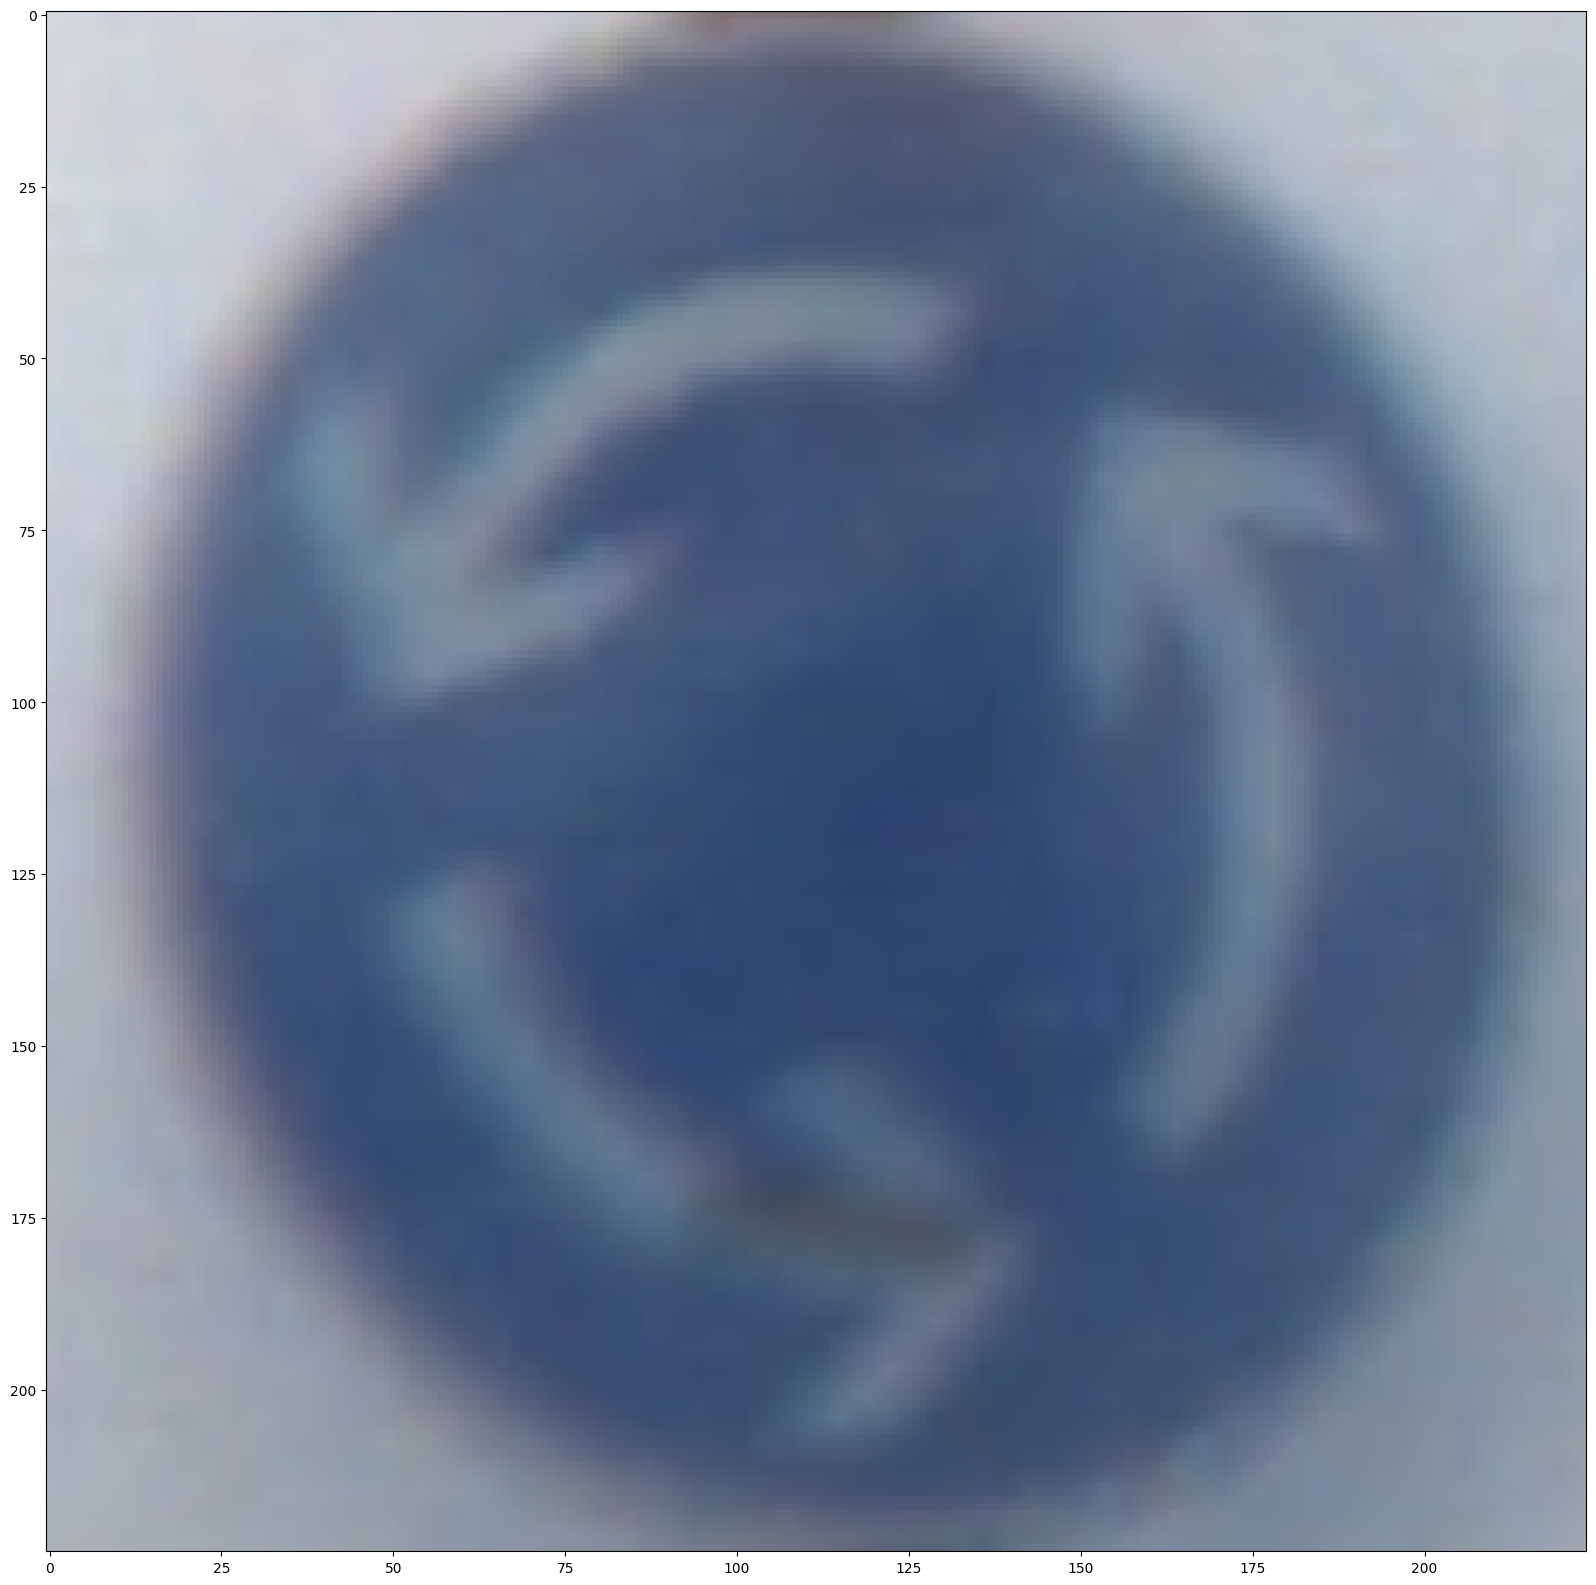

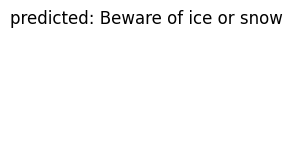

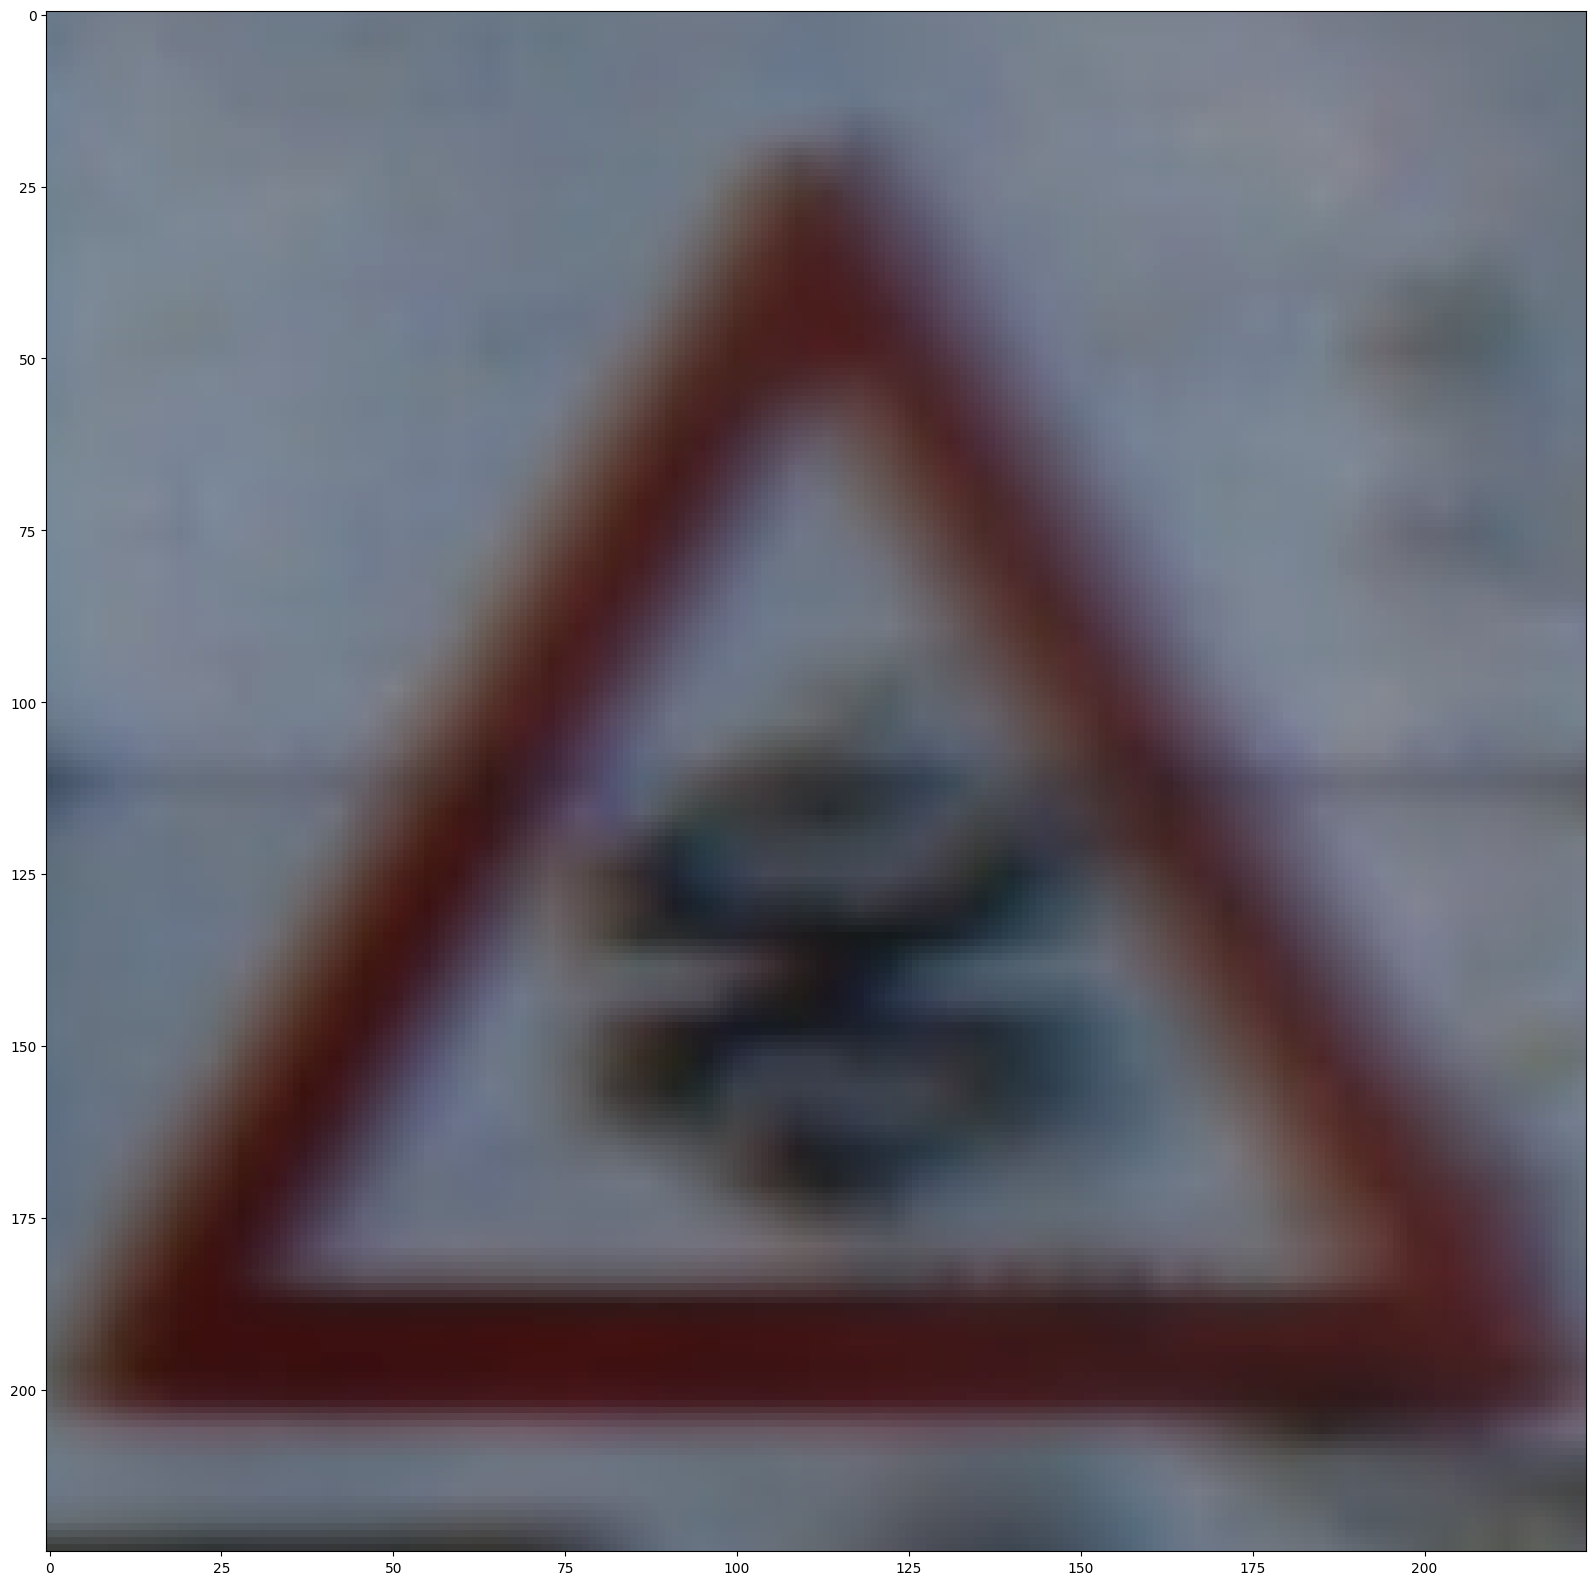

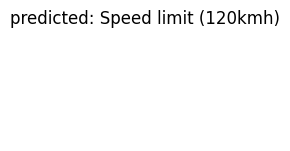

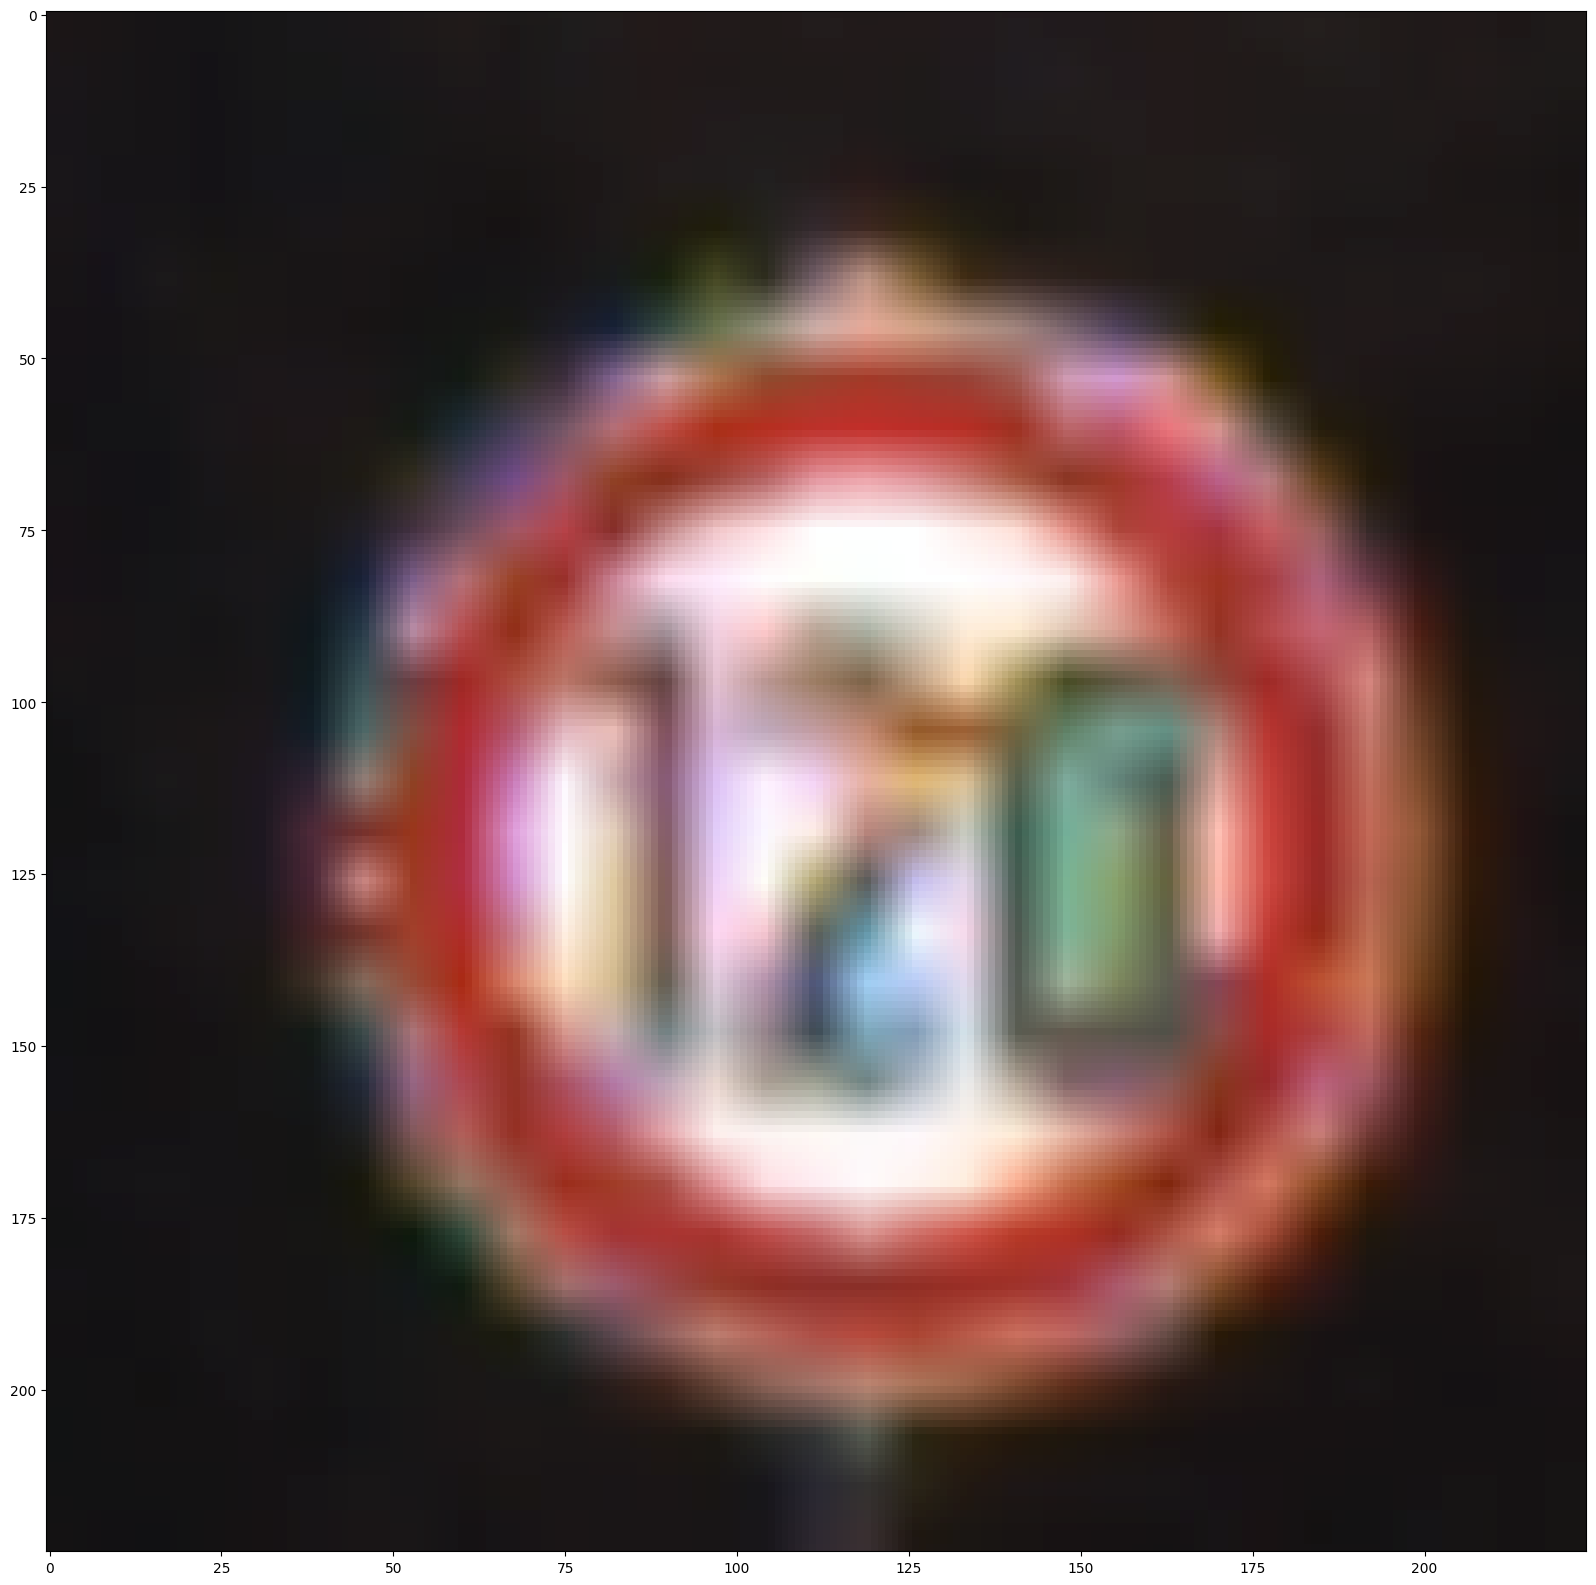

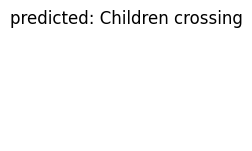

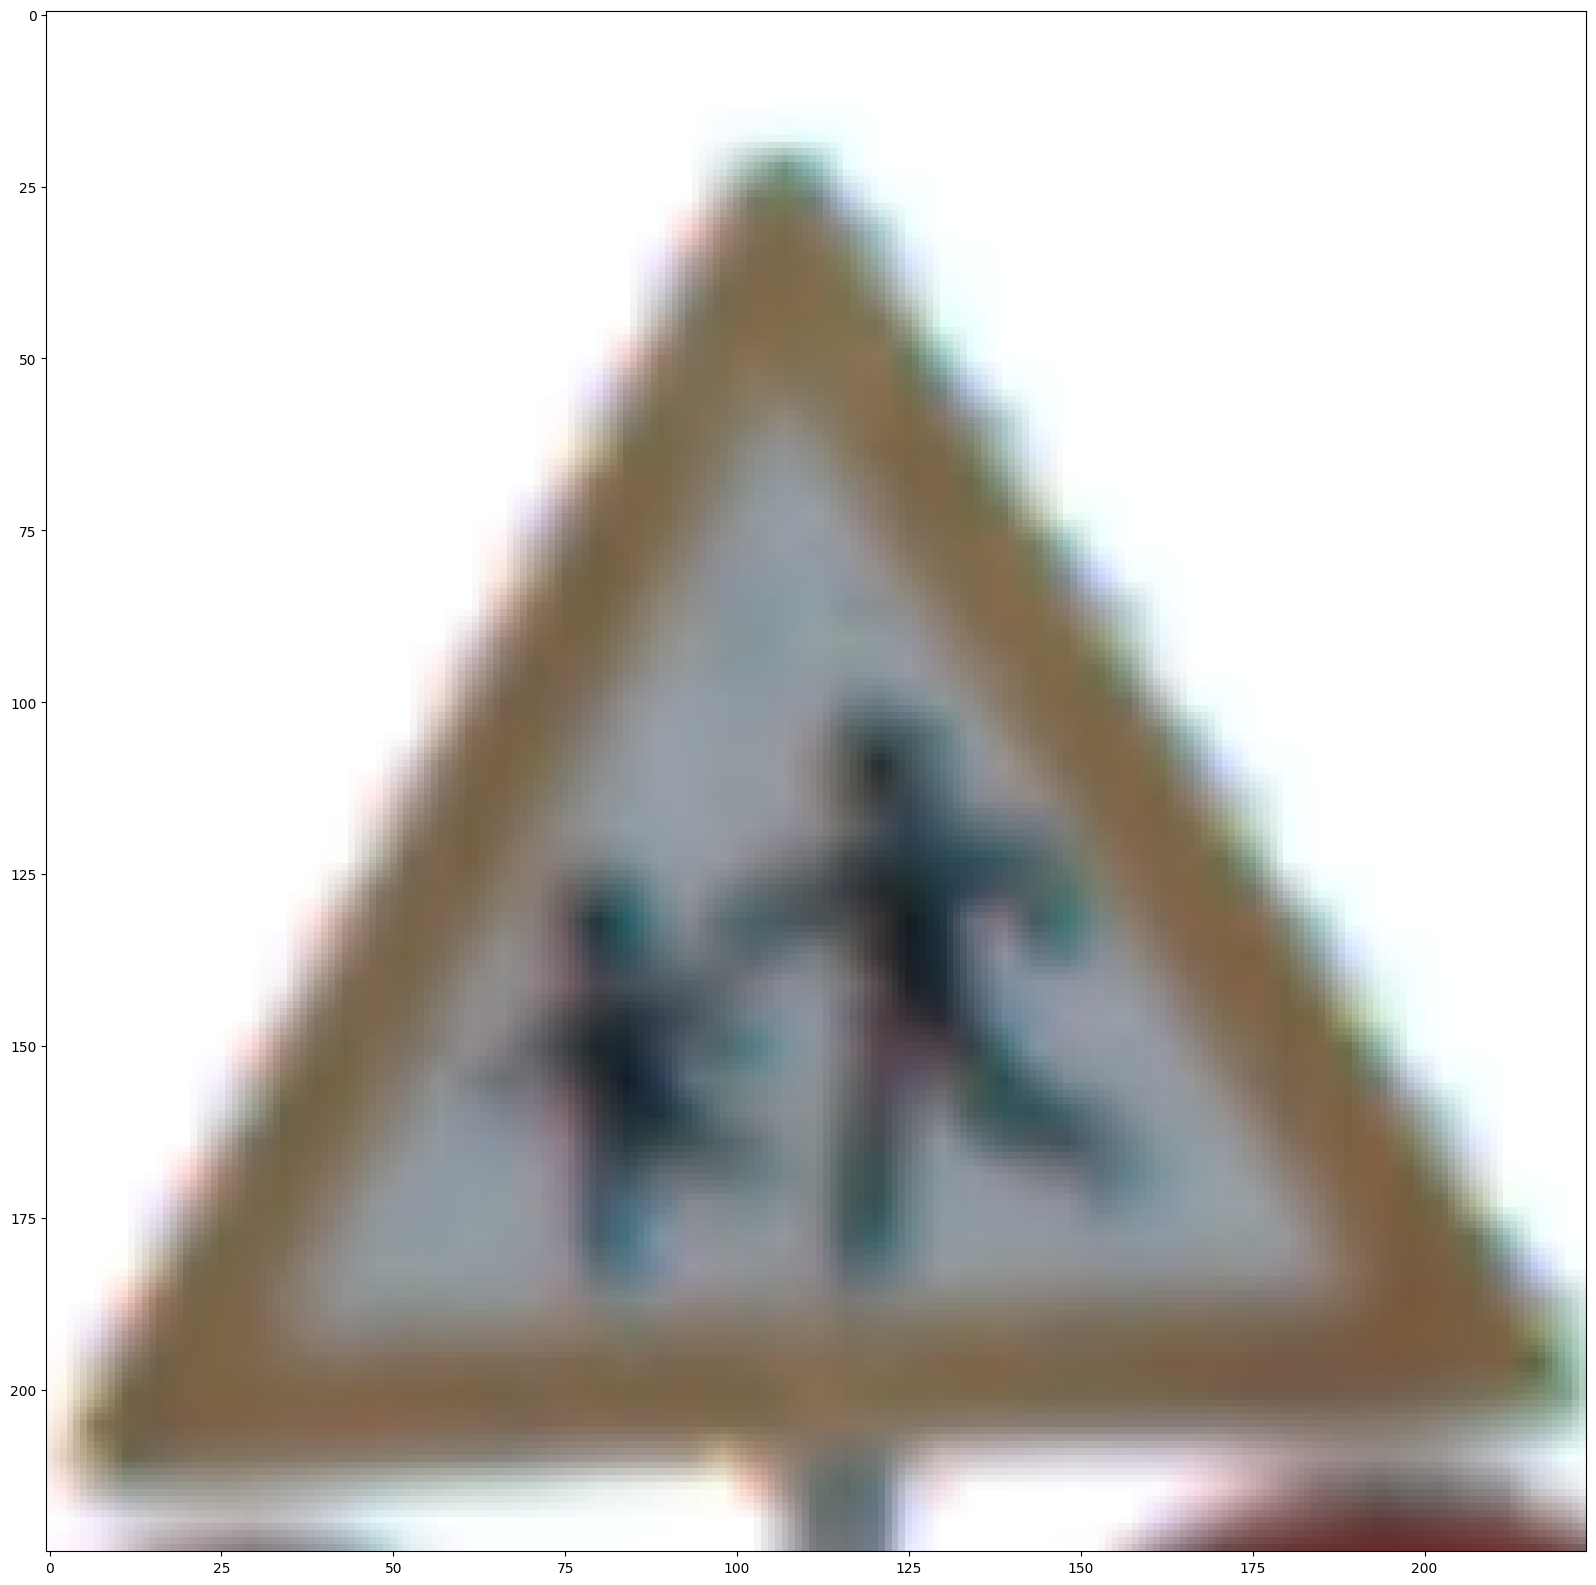

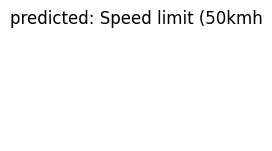

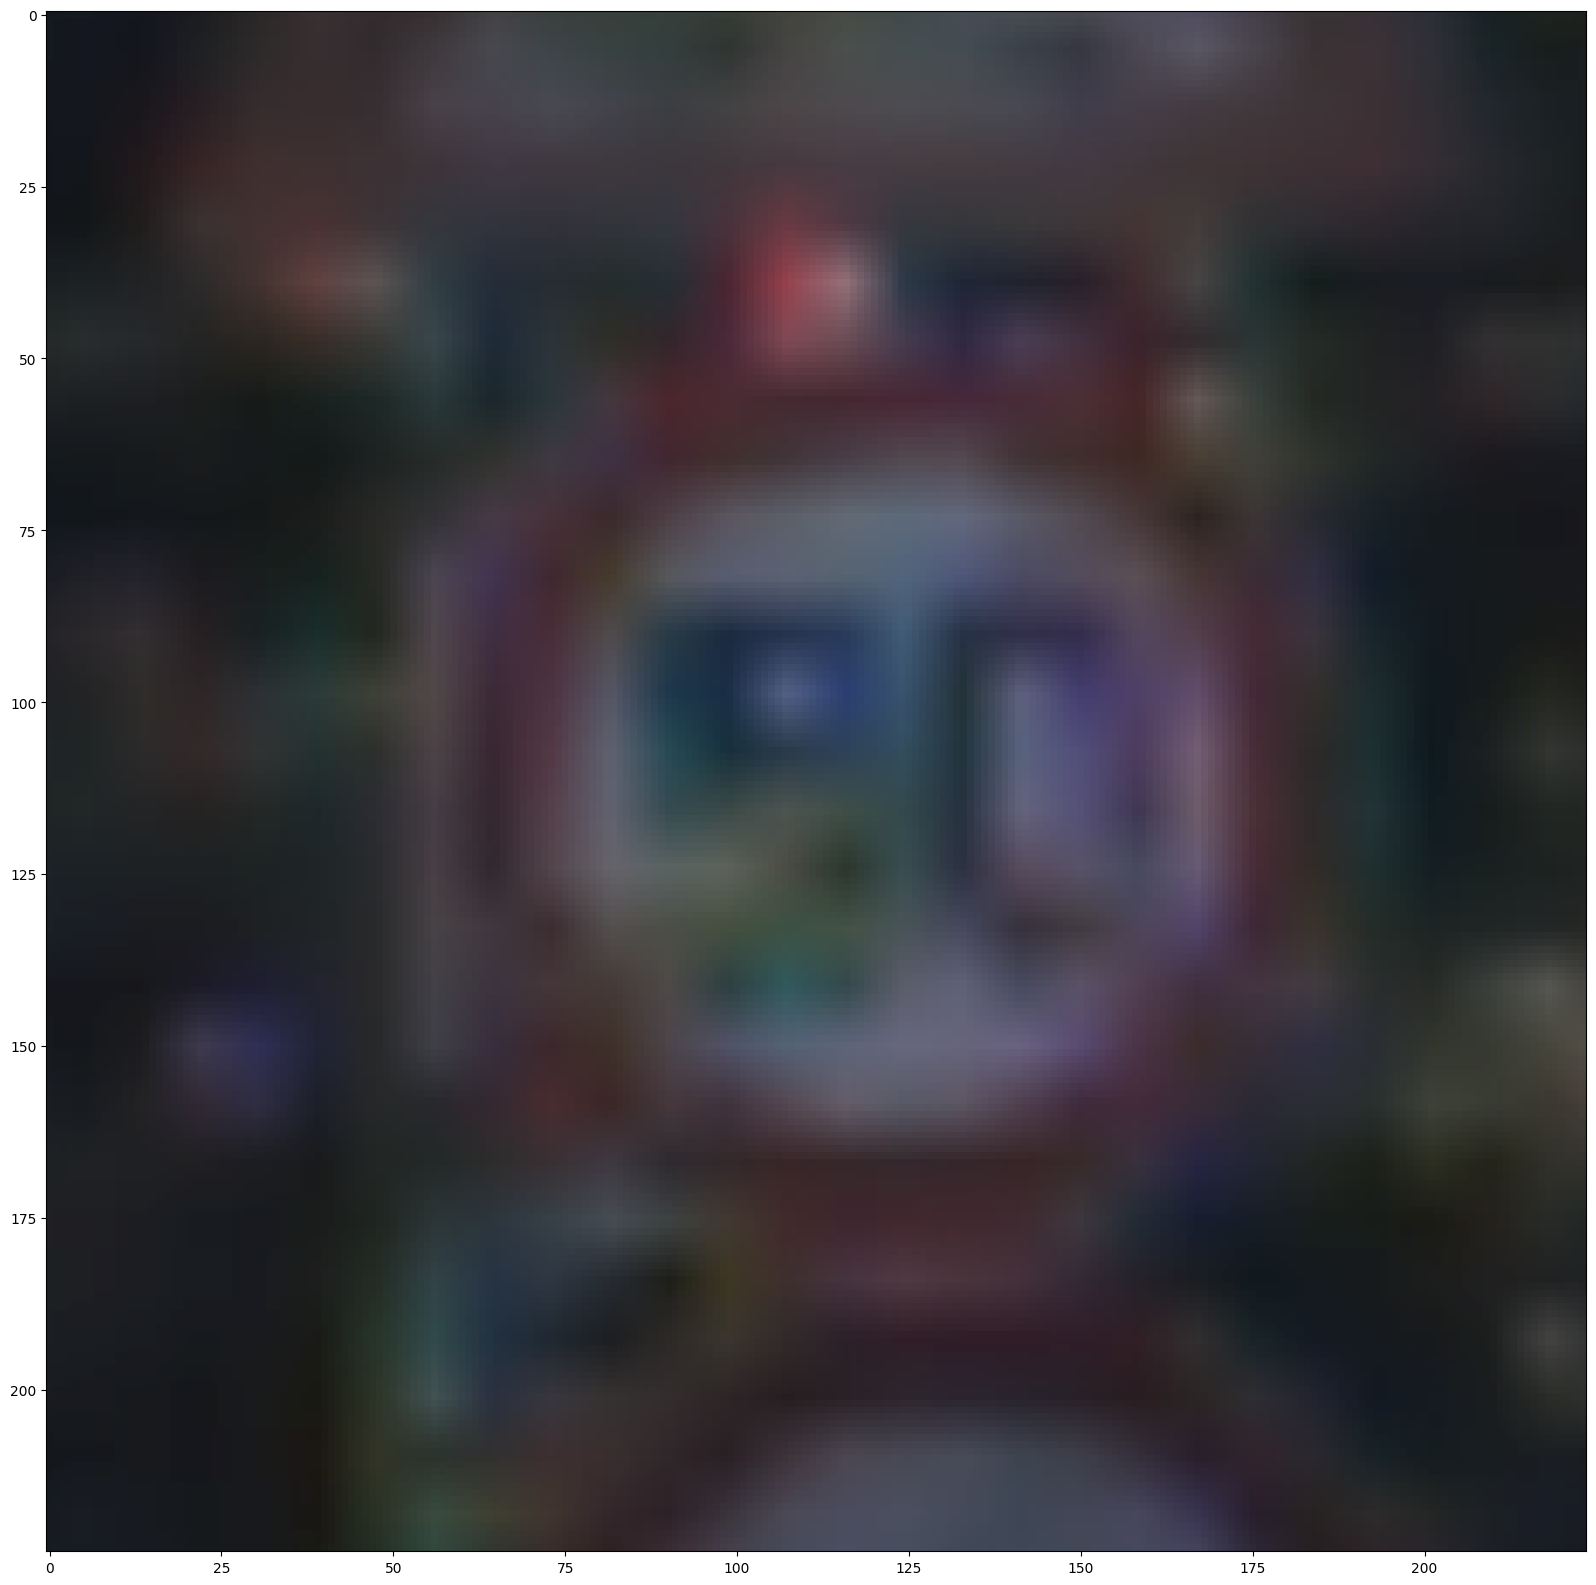

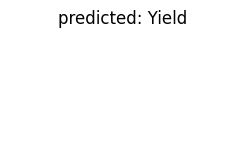

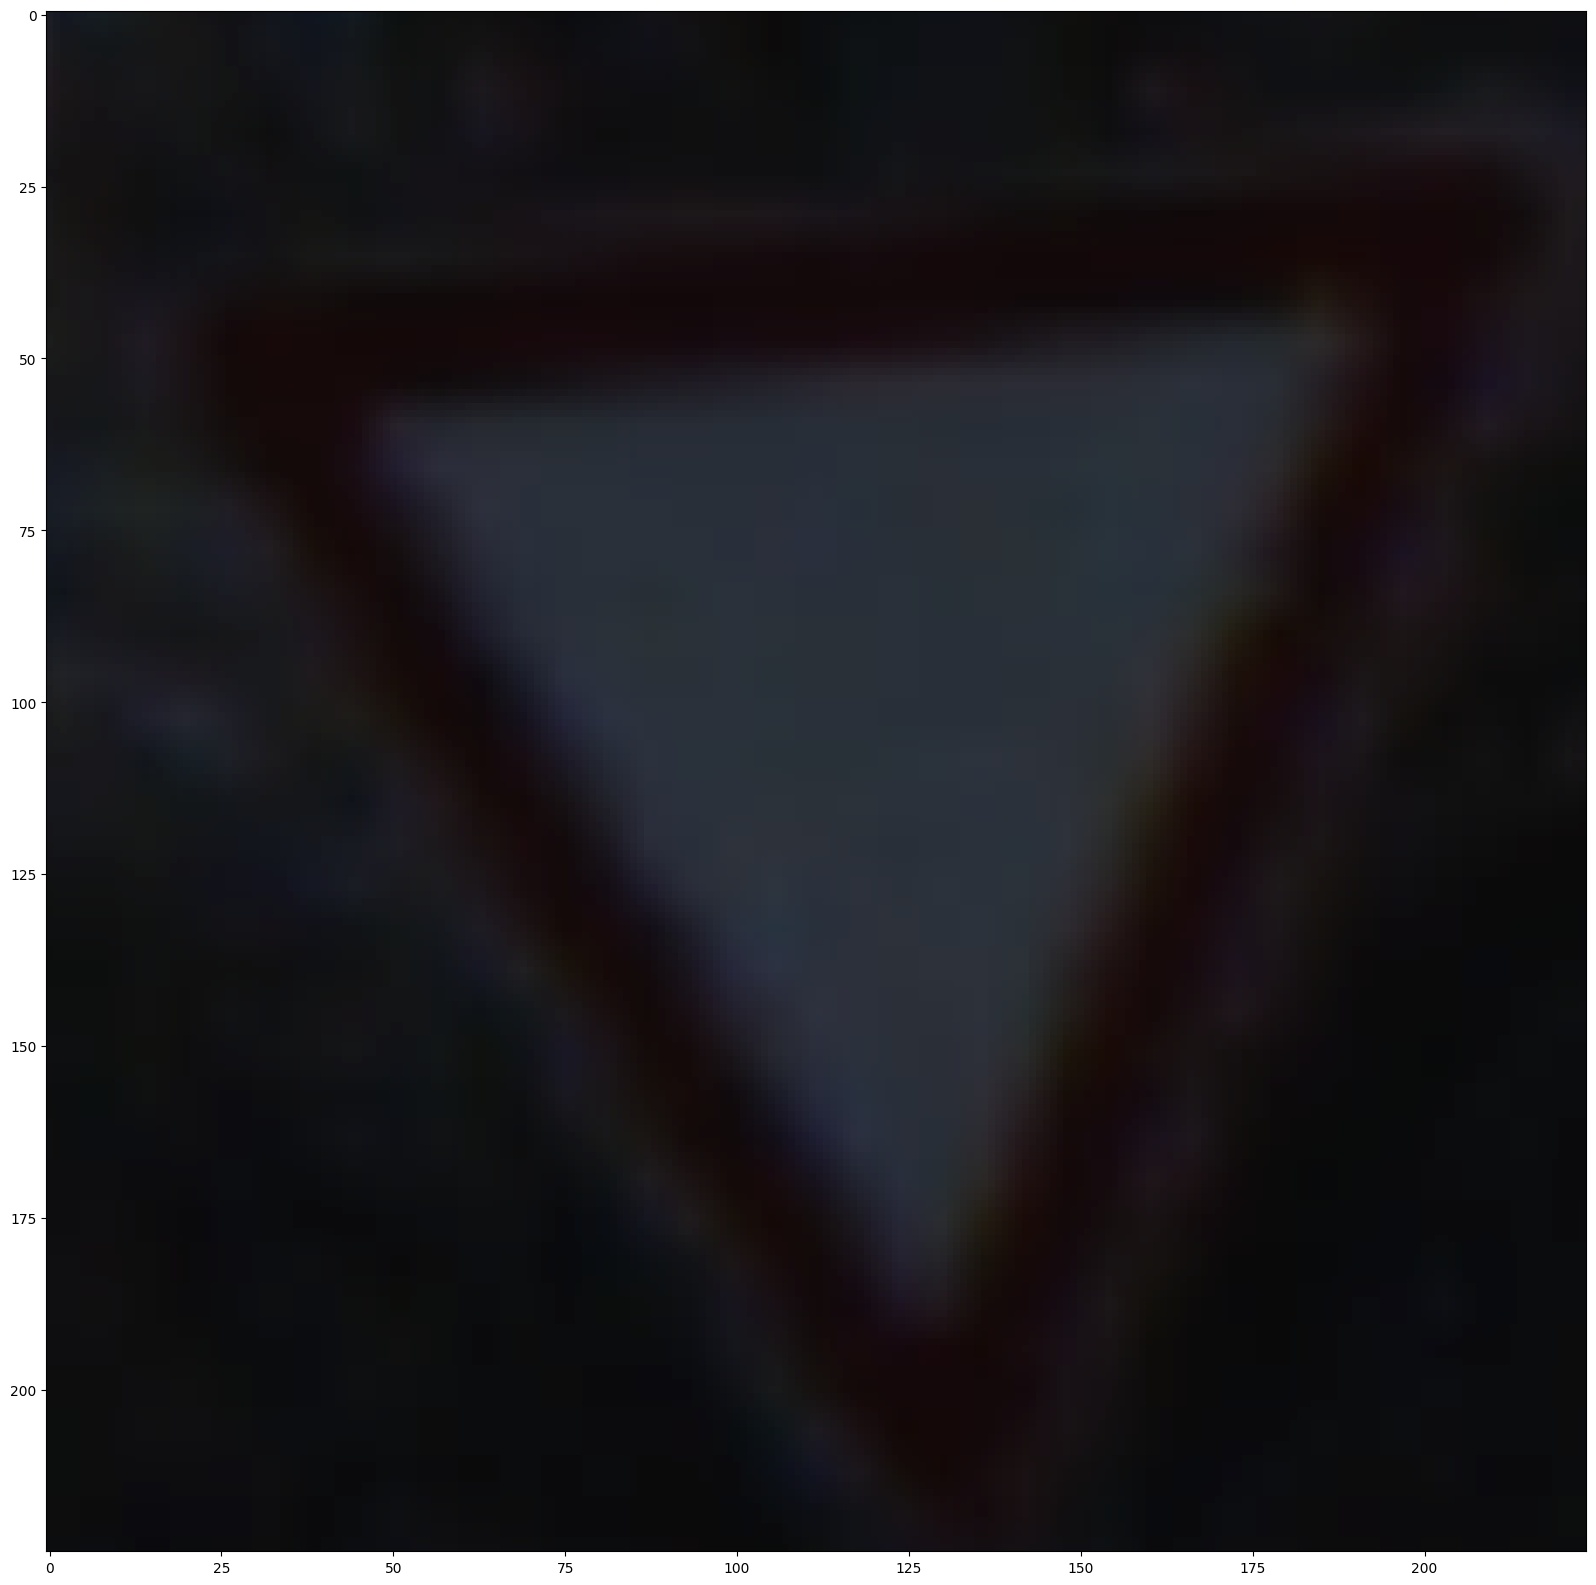

In [13]:
visualize_model(model_ft)

#### ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward().

In [14]:
model_conv = torchvision.models.resnet18(pretrained =True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs= model_conv.fc.in_features
number_of_classes =43
model_conv.fc= nn.Linear(num_ftrs,number_of_classes)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(),lr=0.001, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size =7, gamma=0.1)

### Train and evaluate

In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.6663 Acc: 0.3244
test Loss: 1.9061 Acc: 0.4941

Epoch 1/24
----------
train Loss: 1.9921 Acc: 0.4780
test Loss: 1.4948 Acc: 0.5989

Epoch 2/24
----------
train Loss: 1.7591 Acc: 0.5241
test Loss: 1.2778 Acc: 0.6470

Epoch 3/24
----------
train Loss: 1.6210 Acc: 0.5616
test Loss: 1.1471 Acc: 0.6819

Epoch 4/24
----------
train Loss: 1.5339 Acc: 0.5807
test Loss: 1.0673 Acc: 0.6999

Epoch 5/24
----------
train Loss: 1.4811 Acc: 0.5900
test Loss: 0.9988 Acc: 0.7147

Epoch 6/24
----------
train Loss: 1.4217 Acc: 0.6034
test Loss: 0.9623 Acc: 0.7223

Epoch 7/24
----------
train Loss: 1.4003 Acc: 0.6101
test Loss: 0.9407 Acc: 0.7353

Epoch 8/24
----------
train Loss: 1.3978 Acc: 0.6093
test Loss: 0.9363 Acc: 0.7374

Epoch 9/24
----------
train Loss: 1.3930 Acc: 0.6081
test Loss: 0.9414 Acc: 0.7360

Epoch 10/24
----------
train Loss: 1.3805 Acc: 0.6136
test Loss: 0.9286 Acc: 0.7405

Epoch 11/24
----------
train Loss: 1.3721 Acc: 0.6176
test Loss: 0.9237 Acc

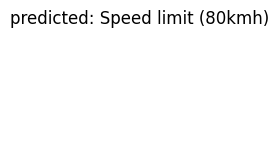

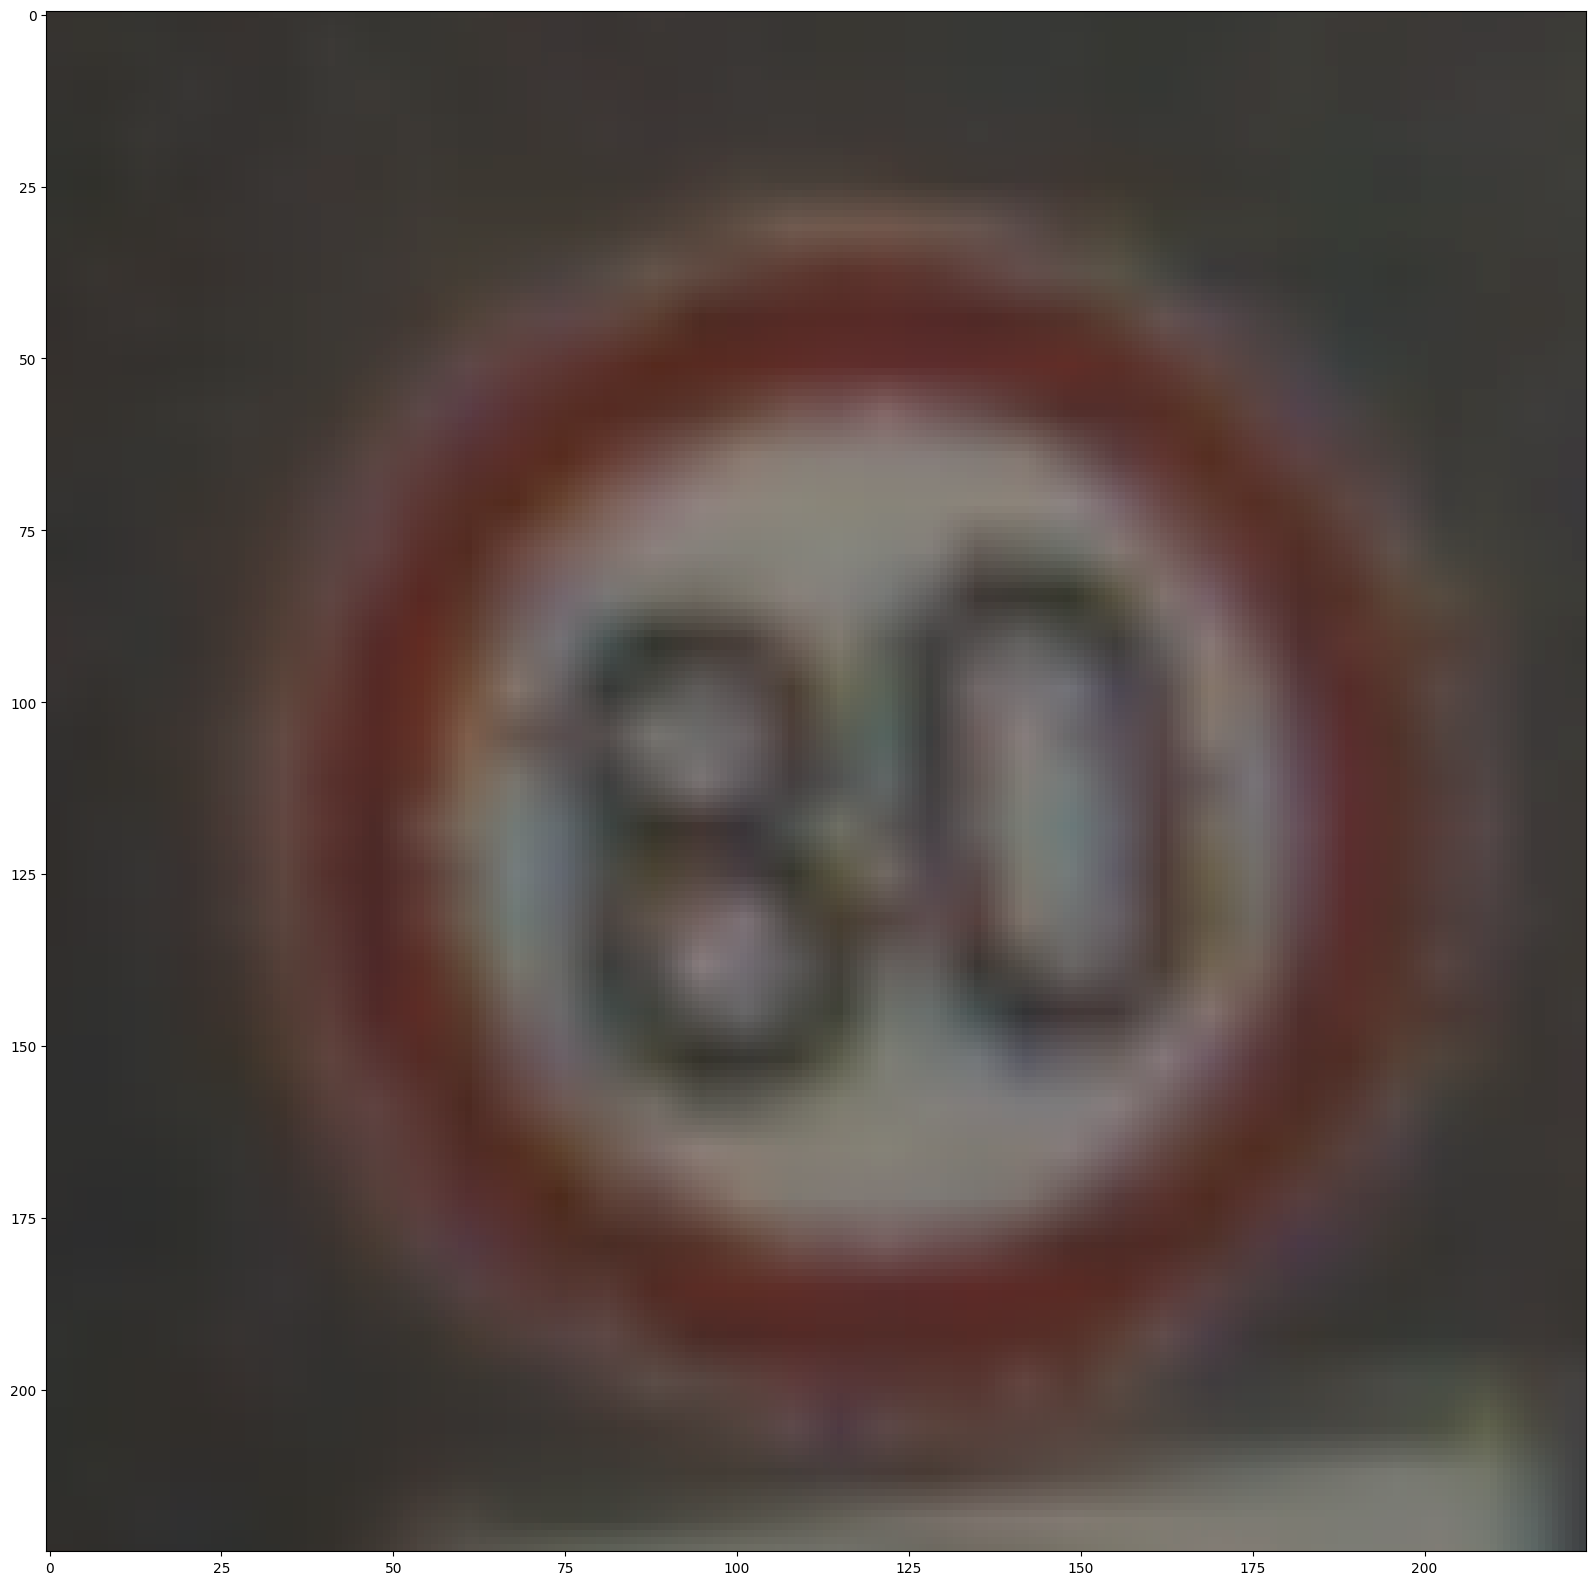

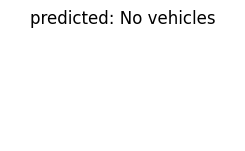

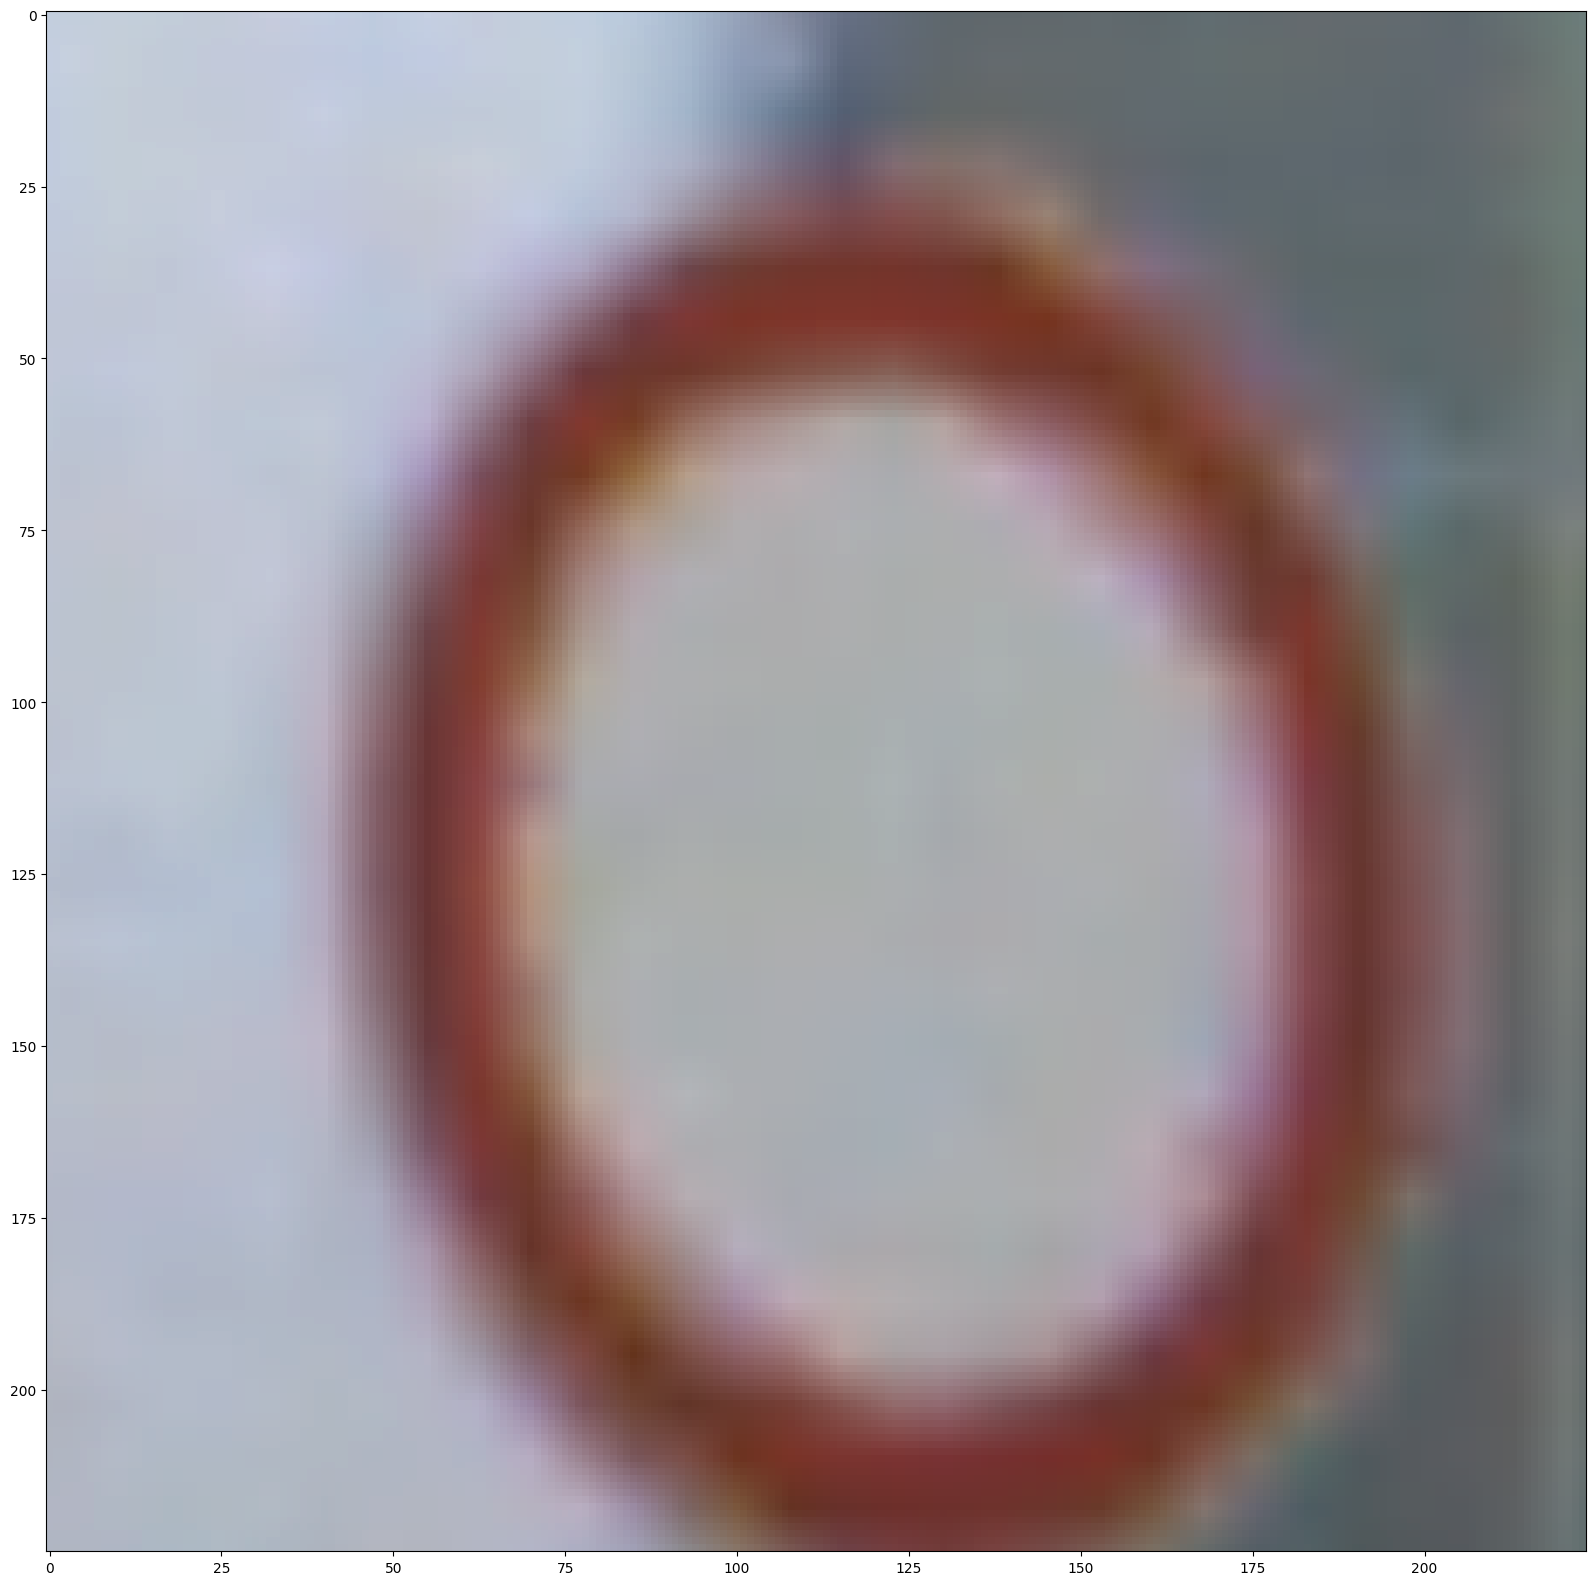

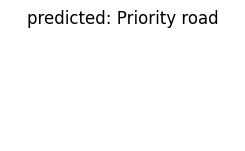

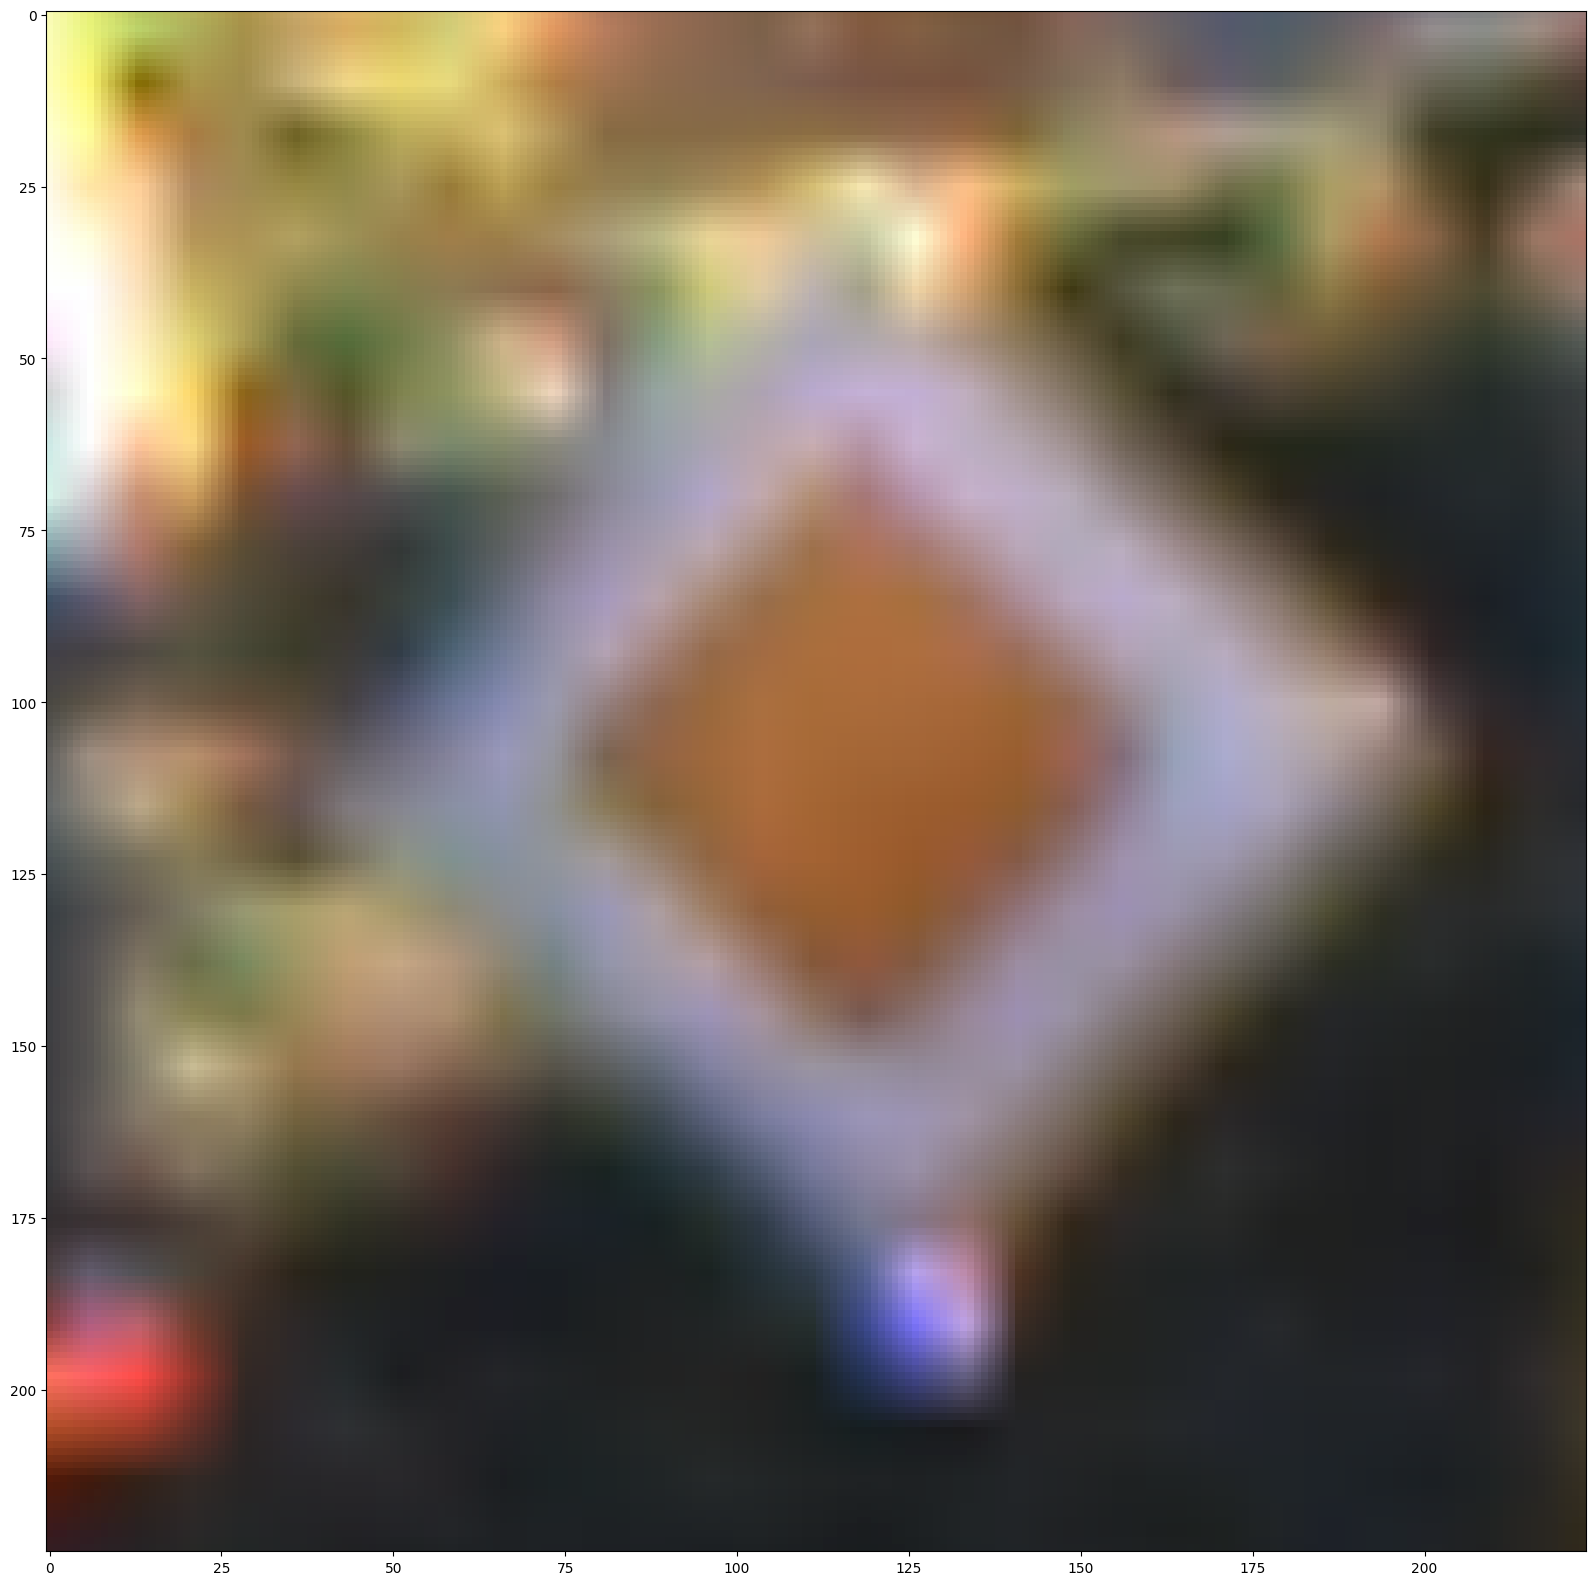

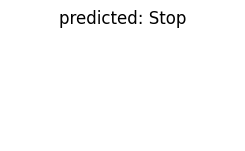

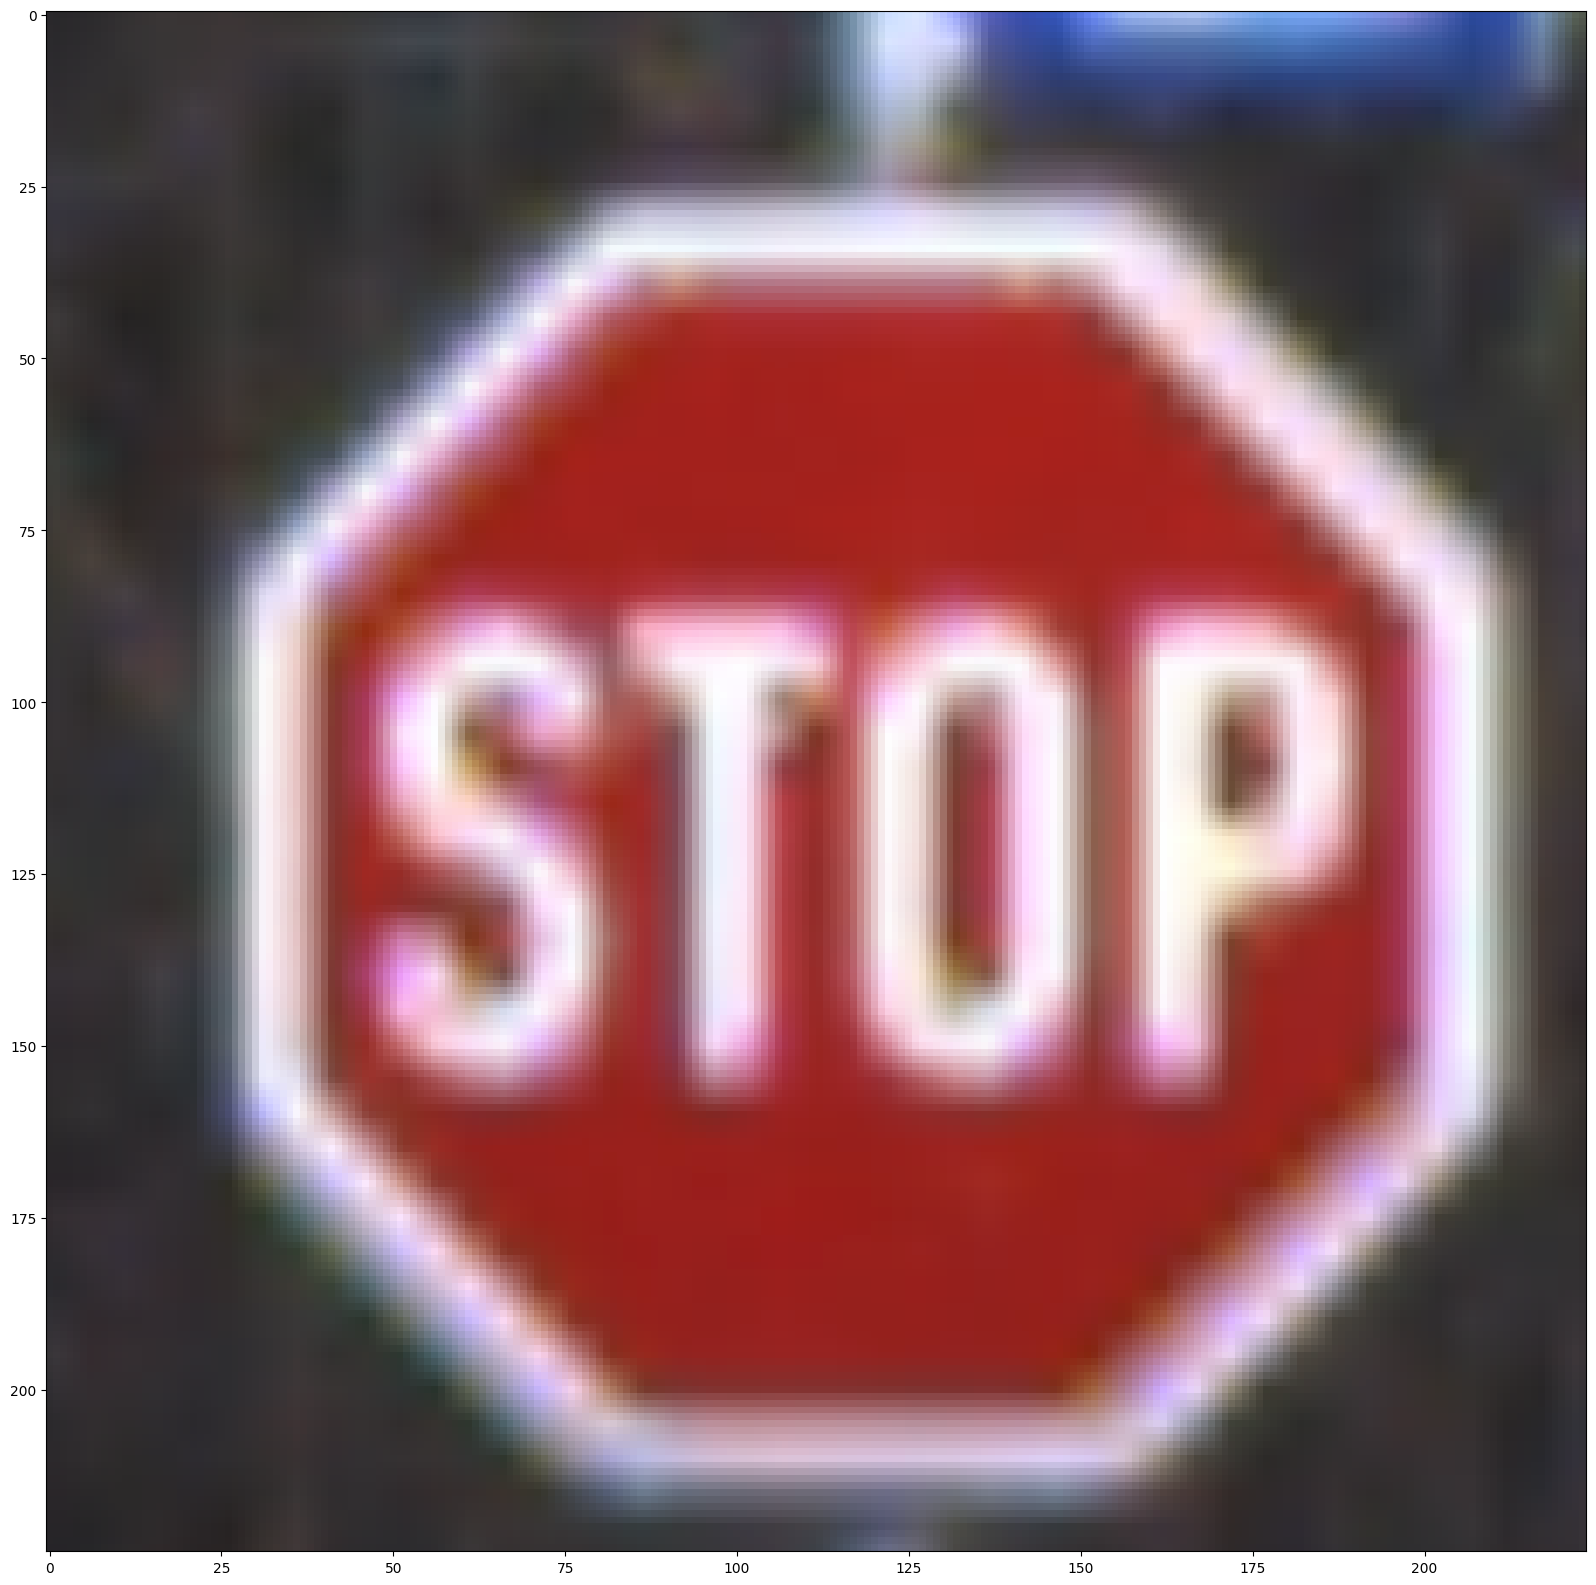

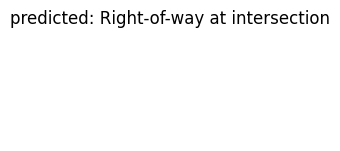

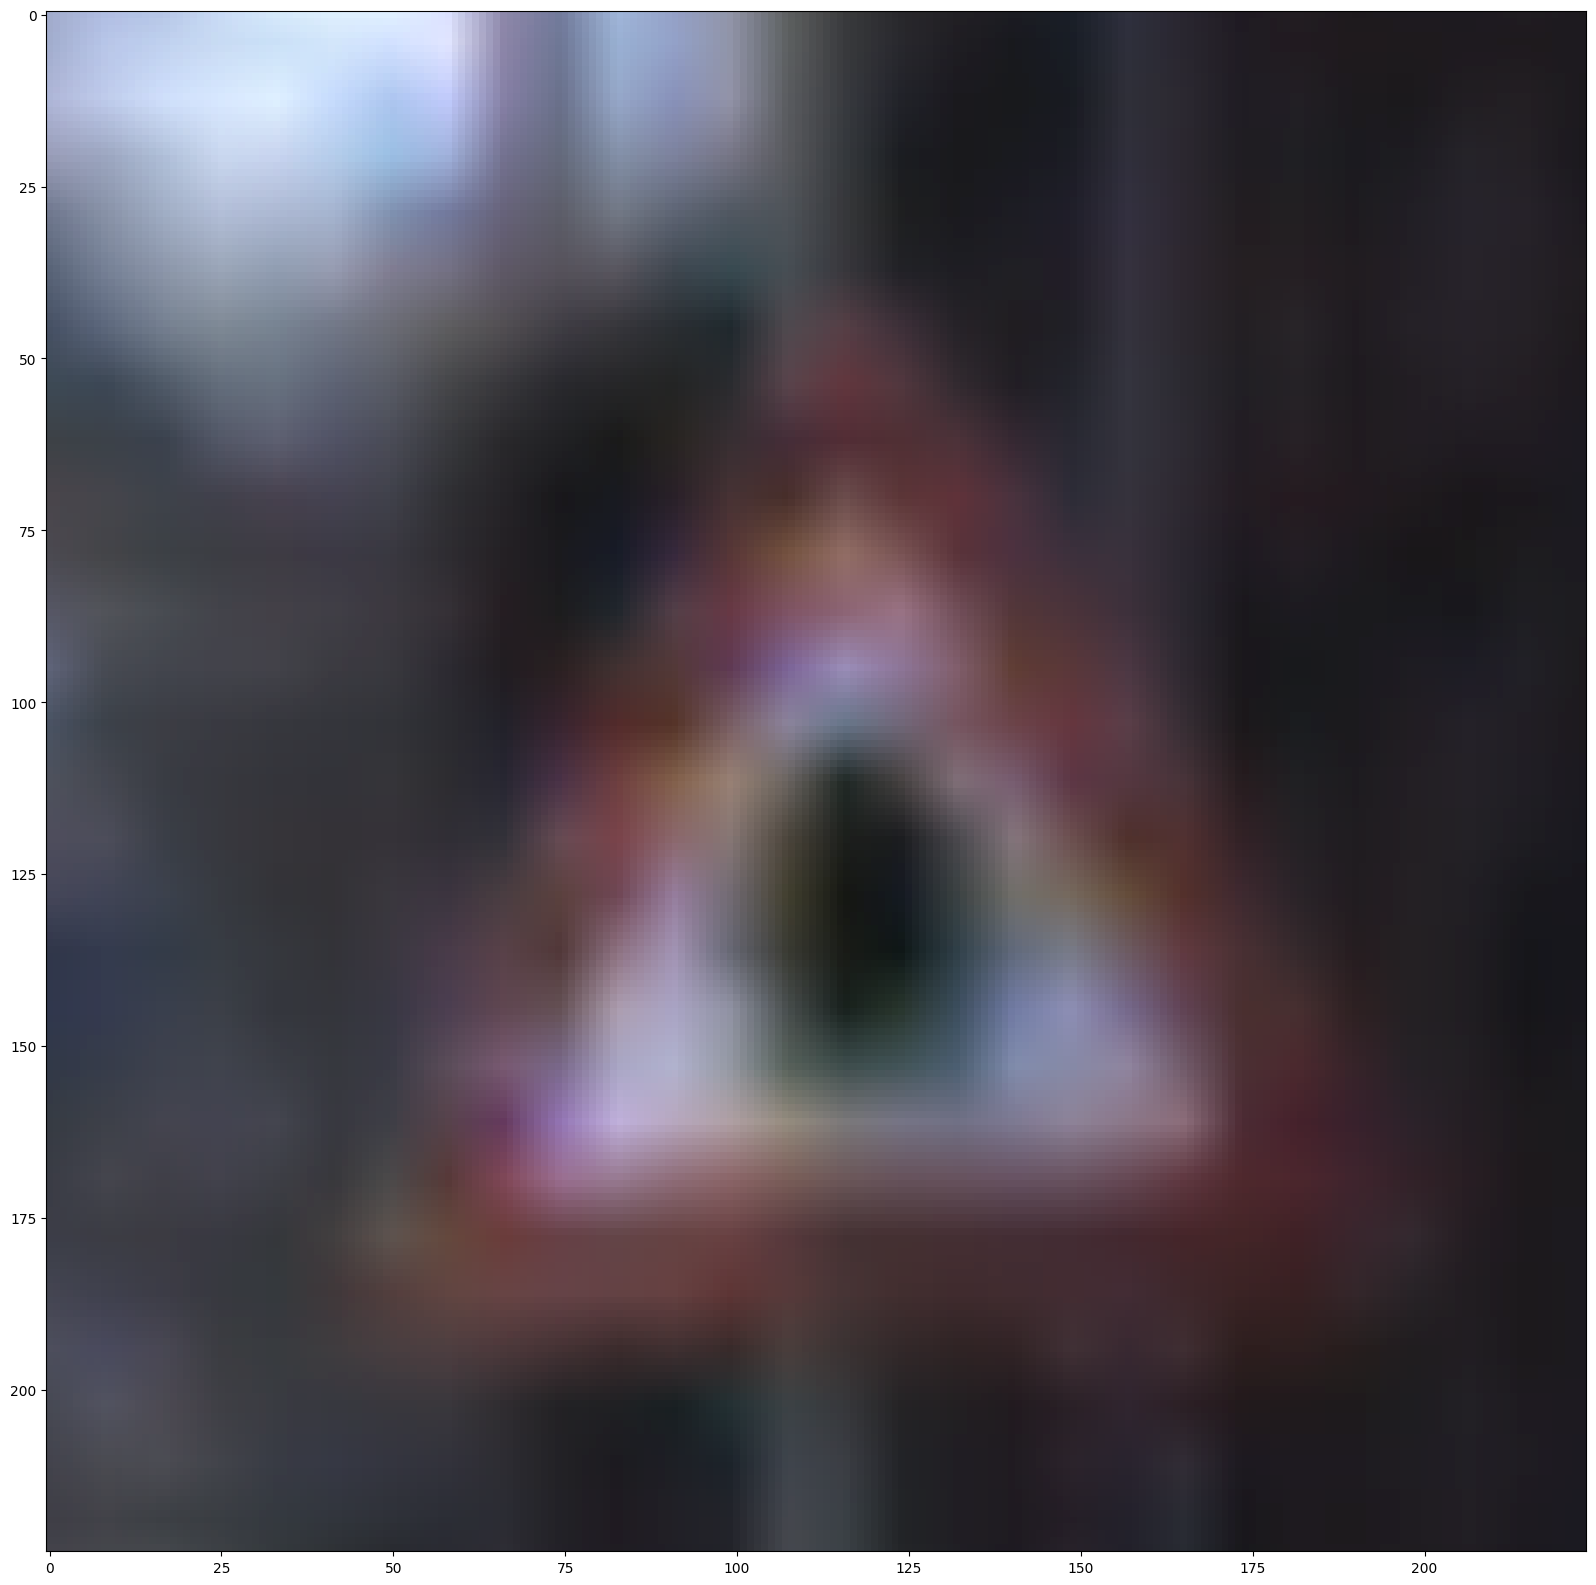

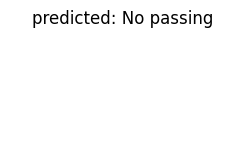

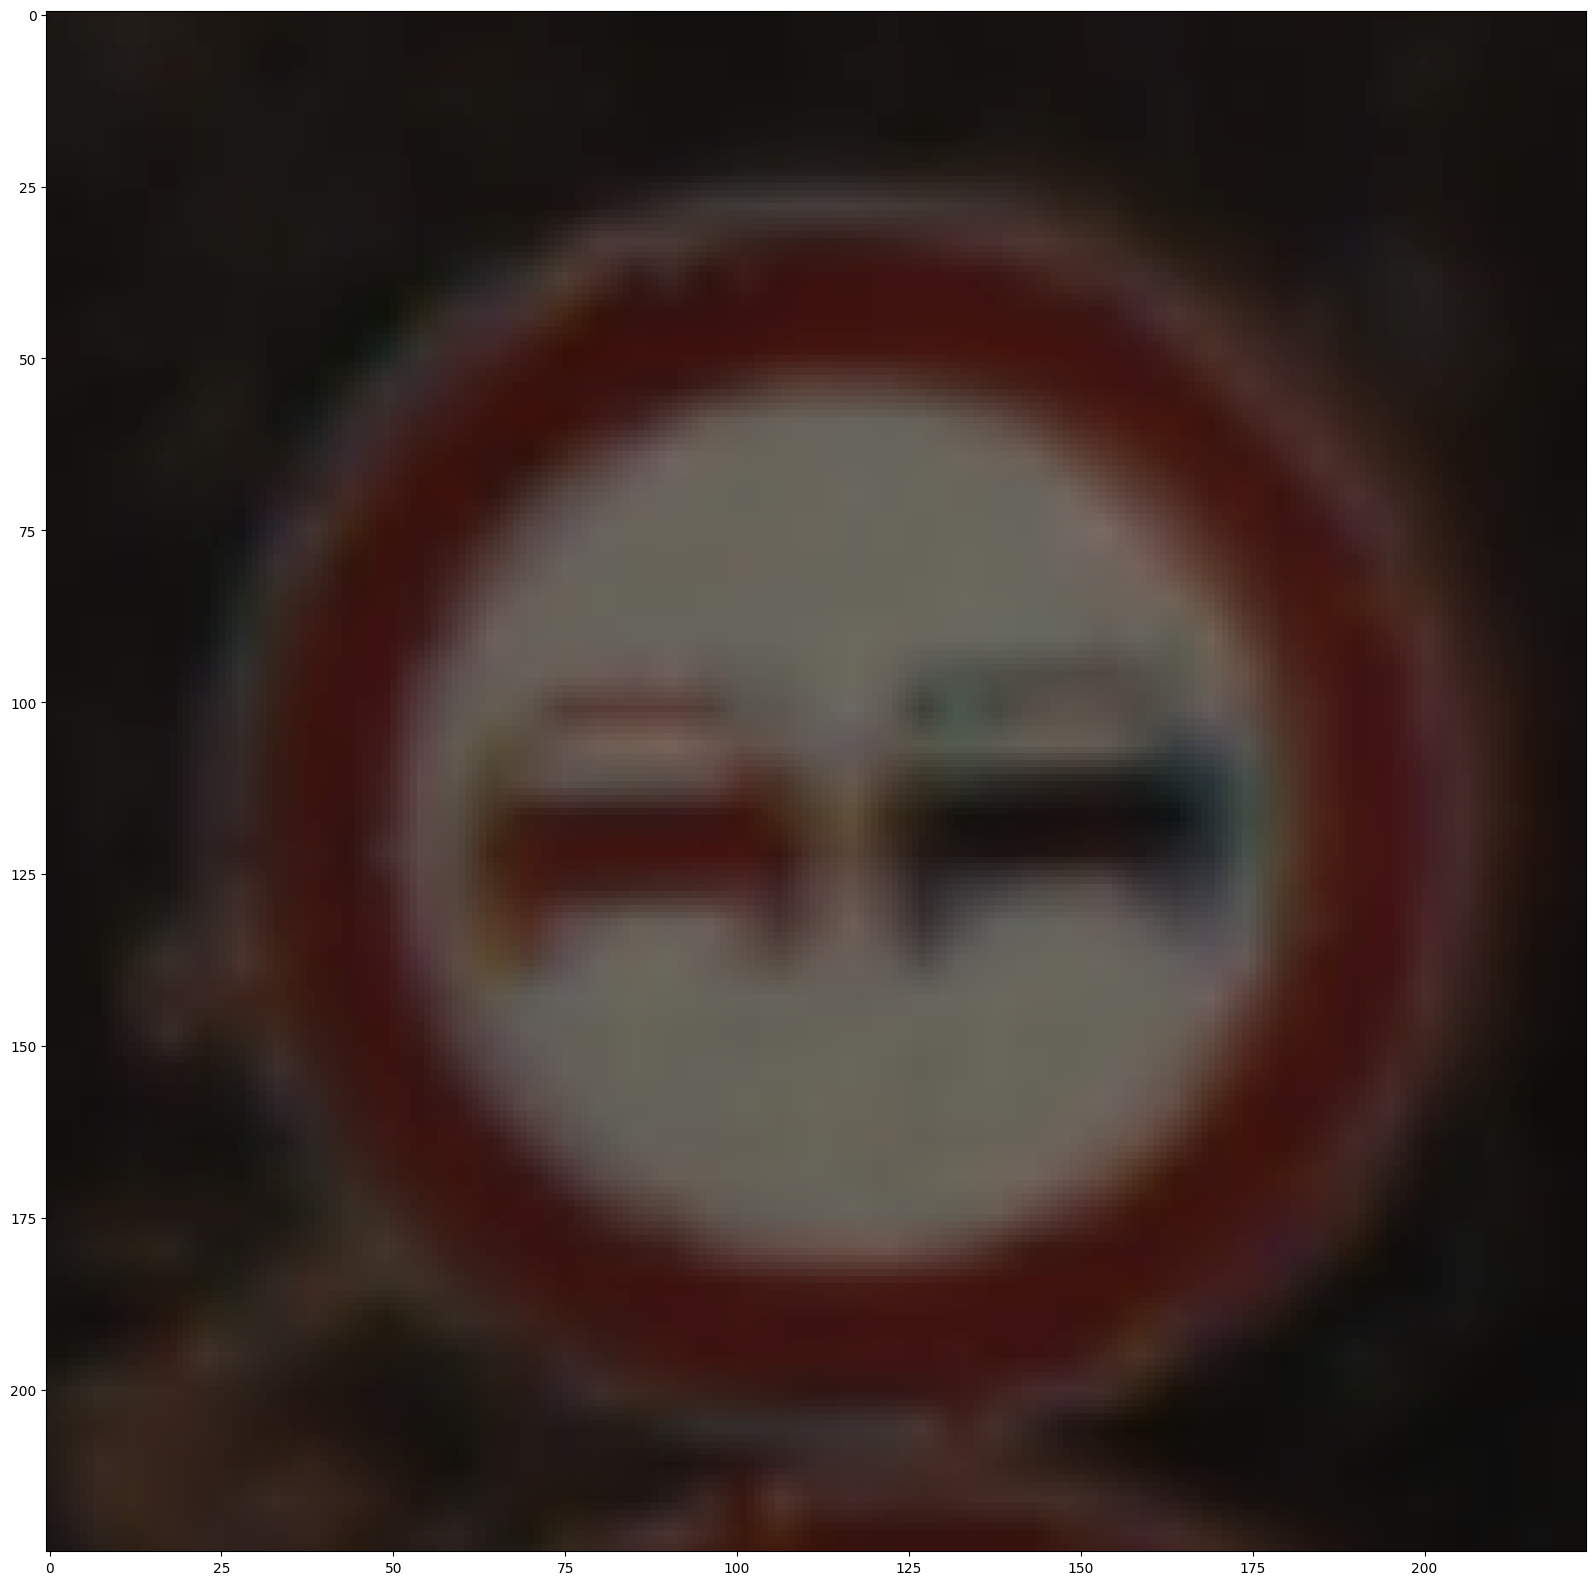

In [16]:
visualize_model(model_conv)

plt.ioff()
plt.show()